In [1]:
import os, csv, snappy
from pathlib import Path
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from snappy import HashMap
import gc   
from snappy import GPF
jpy = snappy.jpy
from snappy import ProductIO, File
from snappy import WKTReader
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

from rasterio.enums import Resampling
import cartopy.crs as ccrs

import rasterio
import rasterio.mask
from rasterio.enums import Resampling
import fiona

In [2]:
##init variables
File = jpy.get_type('java.io.File') #file type   

pc_base_directory = ('C:/Sentinel 3 Data/') 
laptop_base_directory = ('C:/Users/Massimo/Documents/SchoolFolder/ThirdYear/Thesis/MassThesis/src/TIF/AllBandsTiff')

base_directory = laptop_base_directory
k=0
path = Path(base_directory)
print(path)


C:\Users\Massimo\Documents\SchoolFolder\ThirdYear\Thesis\MassThesis\src\TIF\AllBandsTiff


In [3]:
##Malta polygon
shpMalta = gpd.read_file(r'Malta Shape File/MaltaShapeFile.shp') 
geomMalta =str(shpMalta['geometry'][0])# get the geometry of polygon shapefile as string. 
geomMalta = WKTReader().read(geomMalta) #create WKT file from the Shapefile.

##Gozo & Comino polygon
shpGozo = gpd.read_file(r'Malta Shape File/Gozo&Comino.shp') 
geomGozo =str(shpGozo['geometry'][0])# get the geometry of polygon shapefile as string. 
geomGozo = WKTReader().read(geomGozo) #create WKT file from the Shapefile.

##West polygon
shpWest = gpd.read_file(r'Malta Shape File/WestMalta.shp') 
geomWest =str(shpWest['geometry'][0])# get the geometry of polygon shapefile as string. 
geomWest = WKTReader().read(geomWest) #create WKT file from the Shapefile.

##North polygon
shpNorth = gpd.read_file(r'Malta Shape File/NorthMalta.shp') 
geomNorth = str(shpNorth['geometry'][0])# get the geometry of polygon shapefile as string. 
geomNorth = WKTReader().read(geomNorth) #create WKT file from the Shapefile.

##East polygon
shpEast = gpd.read_file(r'Malta Shape File/EastMalta.shp') 
geomEast = str(shpEast['geometry'][0])# get the geometry of polygon shapefile as string. 
geomEast = WKTReader().read(geomEast) #create WKT file from the Shapefile.

In [5]:
#CSV
def write_to_csv( sat, date_format, sensor, time_format, full_name, lst_mean, lst_max, ndvi, lst_mean_east, lst_max_east, lst_mean_west, lst_max_west, ndvi_east, ndvi_west, suhi_max, suhi_mean):
    #print(sat, date_format, sensor, time_format)
    with open('ProcessedDataCSV.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["File Name", "Satellite", "Sensor", "Date", "Time", "LST_MEAN", "LST_MAX", "NDVI_MEAN", "SUHI_MAX", "SUHI_MEAN"])

        for i in range(len(sat)):
            writer.writerow([full_name[i], sat[i], sensor[i], date_format[i], time_format[i], lst_mean[i], lst_max[i], ndvi[i], lst_mean_east[i], lst_max_east[i], lst_mean_west[i], lst_max_west[i], ndvi_east[i], ndvi_west[i],suhi_max[i], suhi_mean[i]]) 

##########################################


In [6]:
def Subset(product, geom):
    par = HashMap()
    par.put('copyMetadata', True)
    par.put('geoRegion', geom)
    product = GPF.createProduct('Subset', par, product) #Spatial subset.
    return product

In [7]:
#Plot Image
def plotLstNdvi(lst_band_data, ndvi_band_data, date, time, area):
    ##Heatmap colours
    color = cm.jet
    color.set_bad('white')

    colormap = plt.cm.RdYlGn
    '''
    #plt
    plt.figure(figsize=(20,10))

    #LST    
    plt.subplot(121)     
    plt.imshow(lst_band_data, cmap= color), plt.title(area + ' LST ' + date + ' ' + time)
    plt.colorbar(mappable=color) 
    plt.axis('off')

    #NDVI
    plt.subplot(122)
    #plt.imshow(ndvi_band_data, cmap ='gray'), plt.title('NDVI')
    plt.imshow(ndvi_band_data, cmap = colormap), plt.title(area + ' NDVI ' + date + ' ' + time)
    plt.axis('off')

    plt.show()
    '''
    min = np.nanmin(lst_band_data)
    max = np.nanmax(lst_band_data)

    fig1 = plt.figure(figsize=(20,10))
    fig1.clf()
    ax = fig1.add_subplot(1,1,1)
    ax.set_title(area + ' LST ' + date + ' ' + time + '\n (K°)', fontsize=17, fontweight='bold')
    img = ax.imshow(lst_band_data, cmap=color, interpolation='nearest', vmin=min, vmax=max)
    
    fig1.colorbar(img)
    plt.show()
    
    ##NDVI
    min = np.nanmin(ndvi_band_data)
    max = np.nanmax(ndvi_band_data)

    fig2 = plt.figure(figsize=(20,10))
    fig2.clf()
    ax = fig2.add_subplot(1,1,1) 
    ax.set_title(area + ' NDVI ' + date + ' ' + time, fontsize=17, fontweight='bold')
    img = ax.imshow(ndvi_band_data, cmap=colormap, interpolation='nearest', vmin=min, vmax=max)
    fig2.colorbar(img)
    plt.show()

##########################################


In [9]:
def RasterProduct(shapeFile, product_path):
    File = jpy.get_type('java.io.File')
    reader = snappy.ProductIO.getProductReader('SEN3')

    with fiona.open(shapeFile, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(product_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.descriptions
        out_meta = src.meta
        out_meta.update({"driver": "GTiff",
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": out_transform,
                        "dtype": "float32"})
        with rasterio.open('temp.tif', 'w', **out_meta) as dst:
            # Read the data from the window and write it to the output raster
            dst.meta
            dst.update_tags(**out_meta)
            dst.write(out_image)

    raster = rasterio.open('temp.tif')

    # Data visualization units.
    #unit = '[ K ]'
    unit = '[ °C ]'

    long_name = 'Sentinel-3 Land Surface Temperature'

    # We need to know the geographical extent of the data, this is contained in the raster object.

    bbox = raster.bounds
    extent=[bbox[0],bbox[2],bbox[1],bbox[3]]
    #extent=[35.7, 36.1, 14.1, 14.6]
    print (bbox)

    upscale_factor = 1

    # resample data to target shape
    data = raster.read(
    out_shape=(
        raster.count,
        int(raster.height * upscale_factor),
        int(raster.width * upscale_factor)
            ),
            resampling=Resampling.bilinear
        )

    # scale image transform
    transform = raster.transform * raster.transform.scale(
    (raster.width / data.shape[-1]),
    (raster.height / data.shape[-2]))

    print('Rescaled size: ',np.shape(data[0,:,:]))

    # Here we set up the parameters needed to display the geographical data correctly.
    fig=plt.figure(figsize=(15, 12))

    # Here we set up a simple Plate Carree geographical projection. This is handled by the Cartopy library.
    #proj = ccrs.epsg(3857)
    #ax = plt.axes(projection=proj)
    ax = plt.axes(projection=ccrs.PlateCarree())

    # The coastline data get downloaded here, there may be a delay the first time you run this notebook.
    #ax.coastlines(resolution='10m')
    #ax.gridlines()
    ax.set_title(long_name, fontsize=20, pad=20.0, fontweight = 'bold')

    # Here we set the colour map for matplotlib. e.g. 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'jet', also
    # selecting which colour to associate with the NODATA value in the map

    color = cm.jet

    color.set_bad('white')

    #The pixel associated to the NODATA values are masked out.

    data = data.astype(np.float16)
    data[data == -32768.0] = np.nan

    # As the product contains the data in Digital Numbers (DN), it is necessary to calibrate them with the SCALE FACTOR and OFFSET values.
    # These can be retrieved from the extended metadata of the file. 

    scale_factor = 0.0020000001

    offset = 290

    cal_data = scale_factor * data - 273 + offset
    #cal_data = data - 273 + offset

    img = plt.imshow(cal_data[4,:,:], cmap = color,extent = extent,transform=ccrs.PlateCarree())

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.05)
    cbar.set_label(unit, fontsize=16, fontweight = 'bold')
    cbar.ax.tick_params(labelsize=14)
    plt.show()   


In [8]:
def histogram(no_nan_lst_band_data, no_nan_ndvi_band_data):
    #NDVI
    fig1 = plt.figure(figsize=(20,10))
    # Give this new figure a subplot, which will contain the histogram itself
    ax = fig1.add_subplot(111)
    # Add a title & (x,y) labels to the plot
    plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
    plt.xlabel("NDVI values", fontsize=14)
    plt.ylabel("Number of pixels", fontsize=14)
    # For the x-axis, we want to count every pixel that is not an empty value
    x = no_nan_ndvi_band_data
    color = 'g'
    # call 'hist` with our x-axis, bins, and color details
    ax.hist(x,bins=30,color=color,histtype='bar', ec='black')
    # Save the generated figure to an external image file
    #fig2.savefig("ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.5)
    plt.show()

    #LST
    # Define a new figure
    fig2 = plt.figure(figsize=(20,10))
    # Give this new figure a subplot, which will contain the histogram itself
    ax = fig2.add_subplot(111)
    # Add a title & (x,y) labels to the plot
    plt.title("LST Histogram", fontsize=18, fontweight='bold')
    plt.xlabel("LST values", fontsize=14)
    plt.ylabel("Number of pixels", fontsize=14)
    # For the x-axis, we want to count every pixel that is not an empty value
    x = no_nan_lst_band_data
    color = 'b'
    # call 'hist` with our x-axis, bins, and color details
    ax.hist(x,bins=30,color=color,histtype='bar', ec='black')
    # Save the generated figure to an external image file
    #fig2.savefig("ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.5)
    plt.show()

In [9]:
##Details about Products
full_name = []
product_name = []
product_paths = []
sat = []
sensor = []
date_format = []
time_format = []

##LST
#Malta
lst_mean = []
lst_max = []
#West
lst_mean_west = []
lst_max_west = []
#East
lst_mean_east = []
lst_max_east = []

##NDVI
ndvi = []
ndvi_east = []
ndvi_west = []

##Data
suhi_max = []
suhi_mean = []

lst_urb_max = [] #hottest pixel
lst_urb_mean = [] #average temp of study area
lst_sur = [] #average temp of surrounding study area
##########################################

Directory open:
['C:/Users/Massimo/Documents/SchoolFolder/ThirdYear/Thesis/MassThesis/src/TIF/AllBandsTiff']
LST mean:
295.2024 Kelvin
22.202392578125 Celcius
Max LST Pixel value: 
298.932 Kelvin
25.9320068359375 Celcius

LST mean West:
295.6561 Kelvin
22.656097412109375 Celcius

Max LST Pixel value West: 
298.932 Kelvin
25.9320068359375 Celcius

LST mean East:
295.89844 Kelvin
22.8984375 Celcius

Max LST Pixel value East: 
298.932 Kelvin
25.9320068359375 Celcius

NDVI mean Malta:
0.38158262

NDVI mean West:
0.3791832

NDVI mean East:
0.36630785

SUHI MAX:
25.552825927734375

SUHI MEAN:
-0.012875348


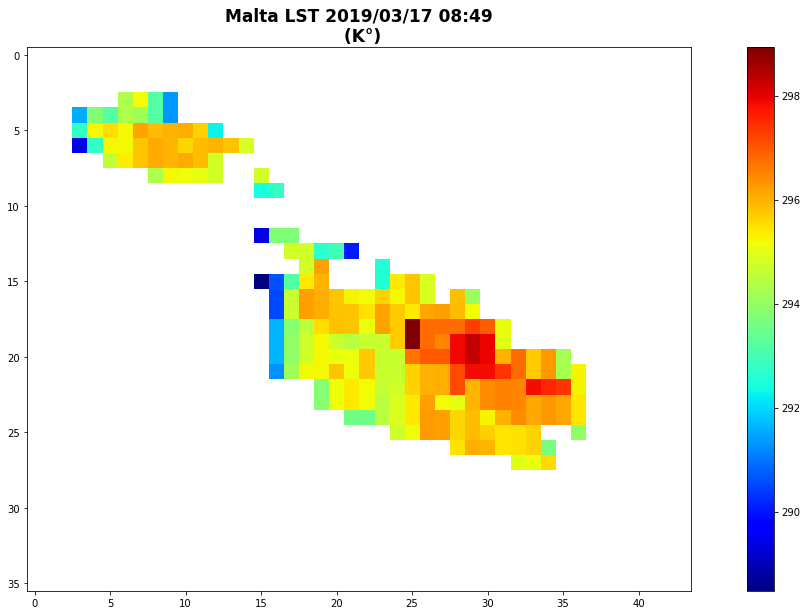

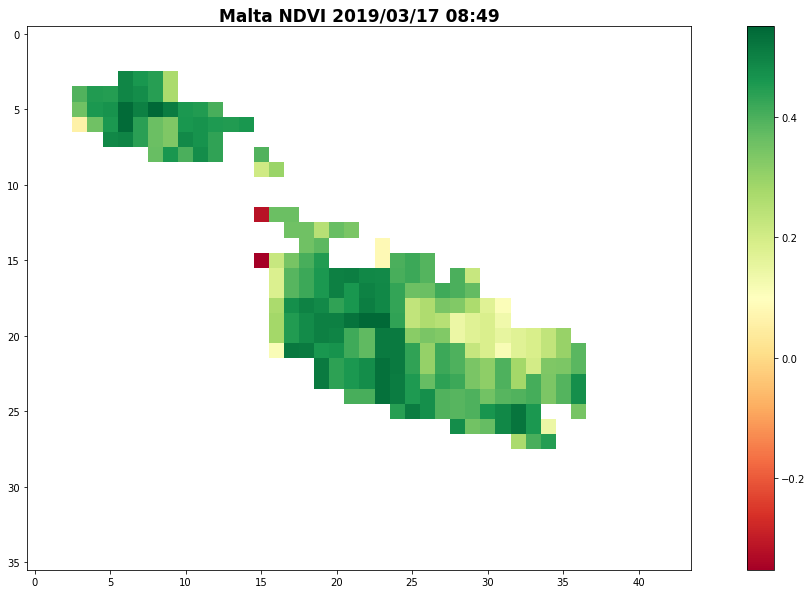

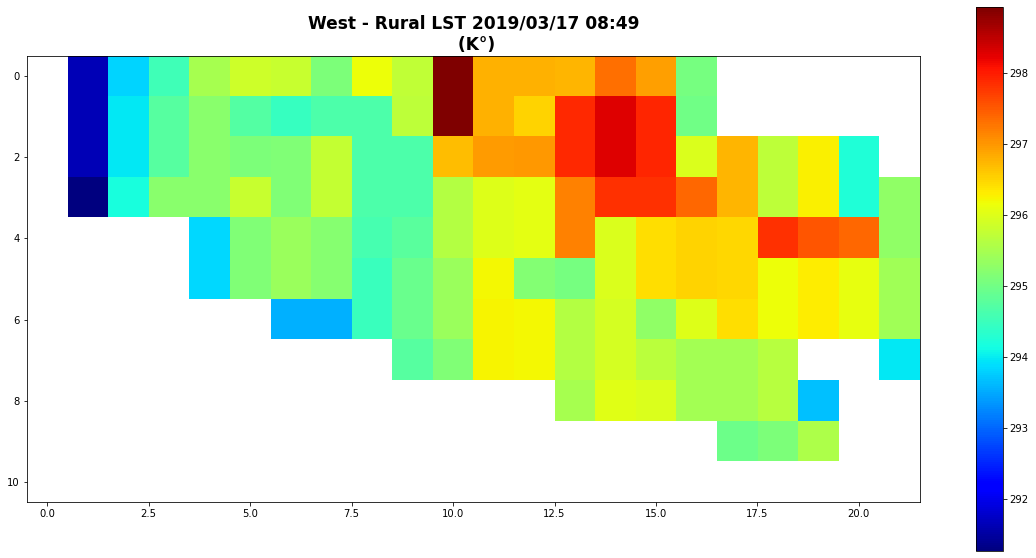

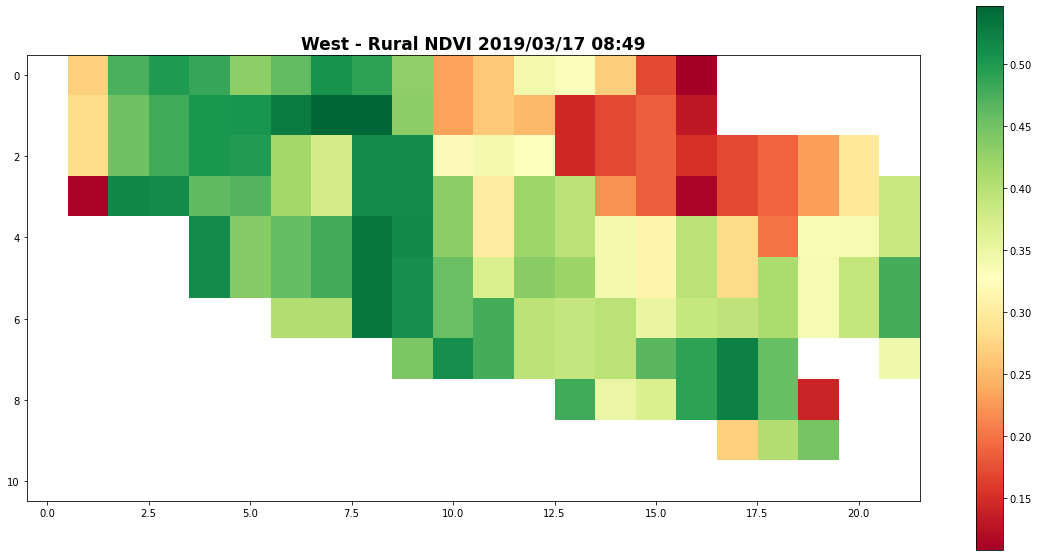

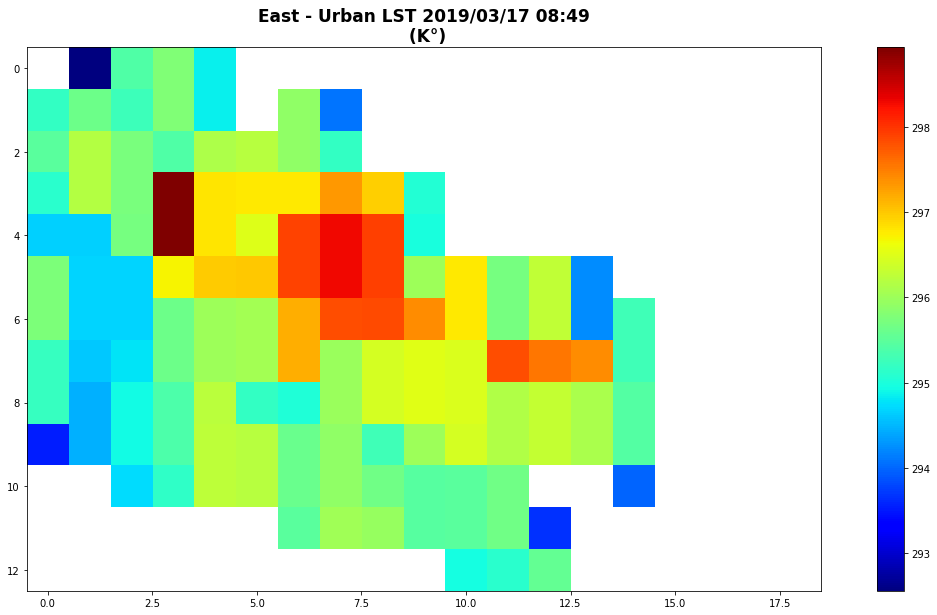

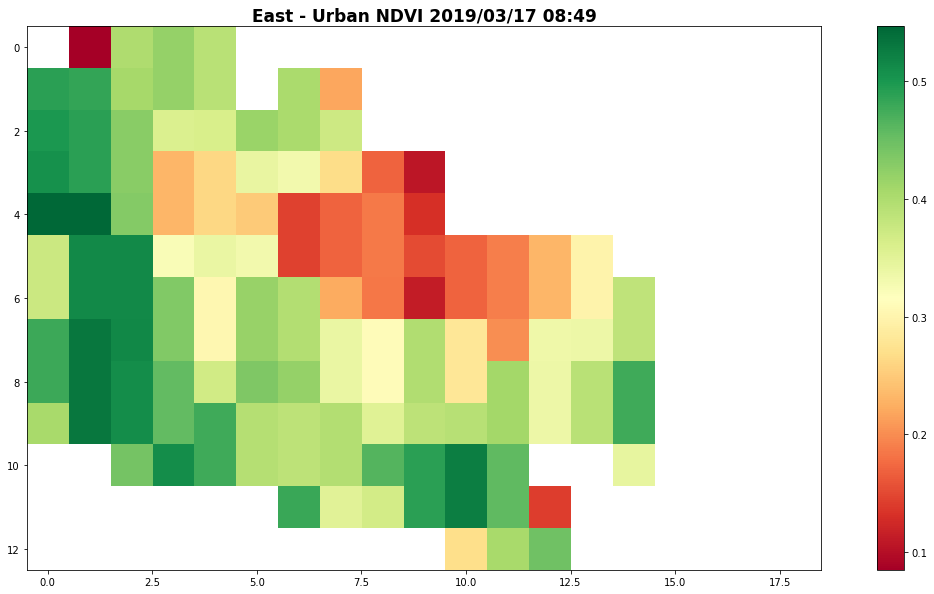

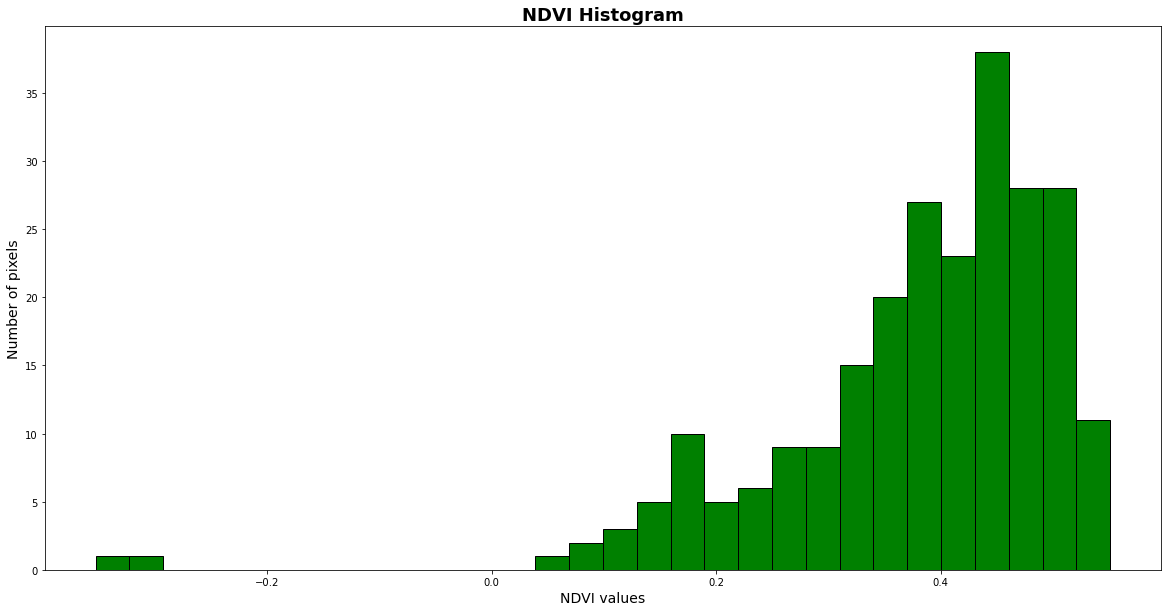

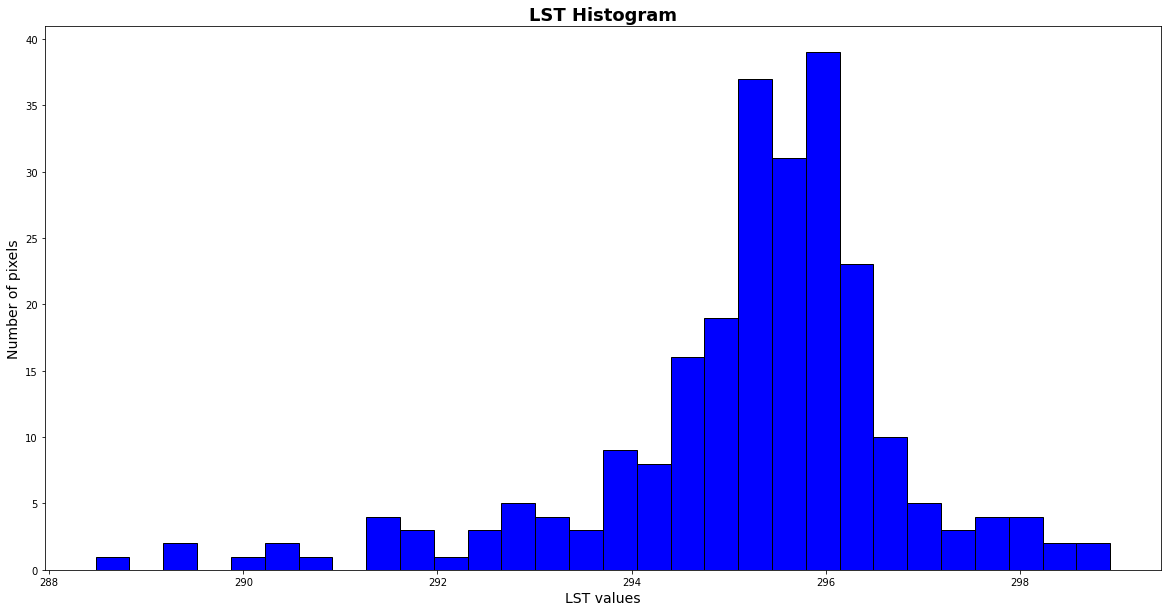

###################


LST mean:
295.8461 Kelvin
22.846099853515625 Celcius
Max LST Pixel value: 
299.78 Kelvin
26.779998779296875 Celcius

LST mean West:
296.12656 Kelvin
23.126556396484375 Celcius

Max LST Pixel value West: 
299.78 Kelvin
26.779998779296875 Celcius

LST mean East:
296.25177 Kelvin
23.25177001953125 Celcius

Max LST Pixel value East: 
299.78 Kelvin
26.779998779296875 Celcius

NDVI mean Malta:
0.41114858

NDVI mean West:
0.40266848

NDVI mean East:
0.37939006

SUHI MAX:
26.3773193359375

SUHI MEAN:
-0.023278415


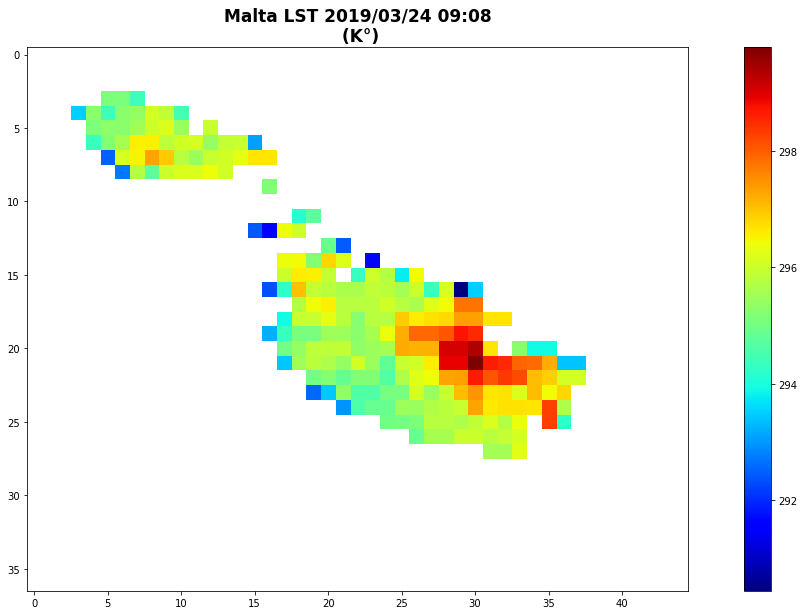

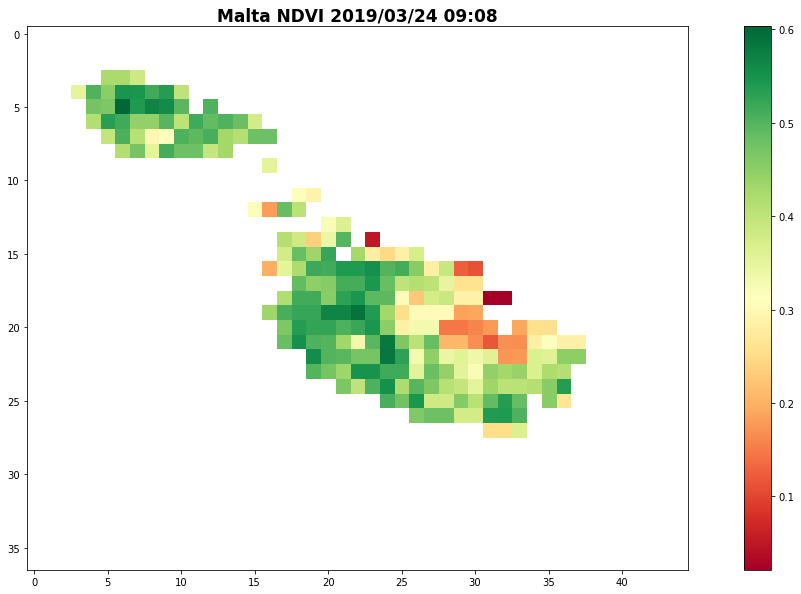

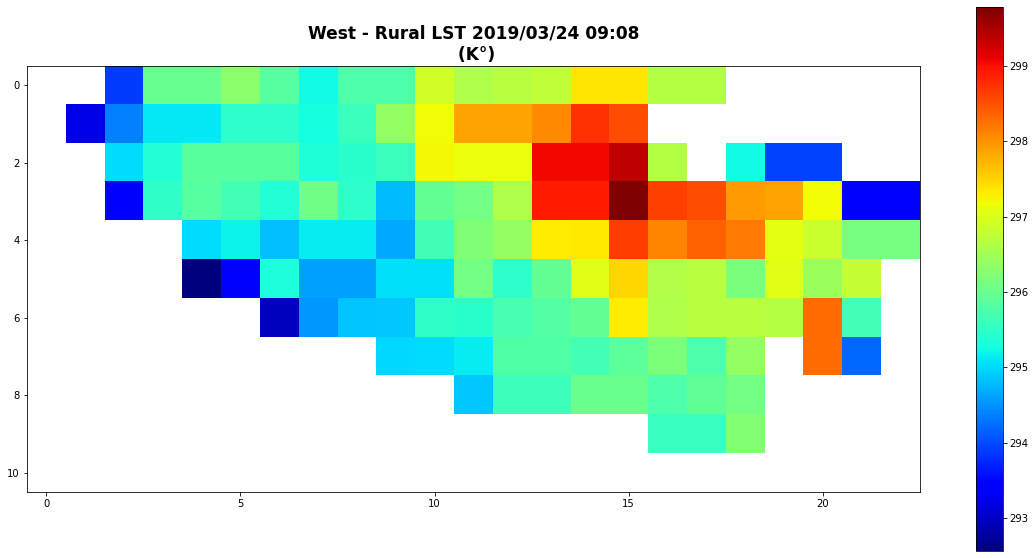

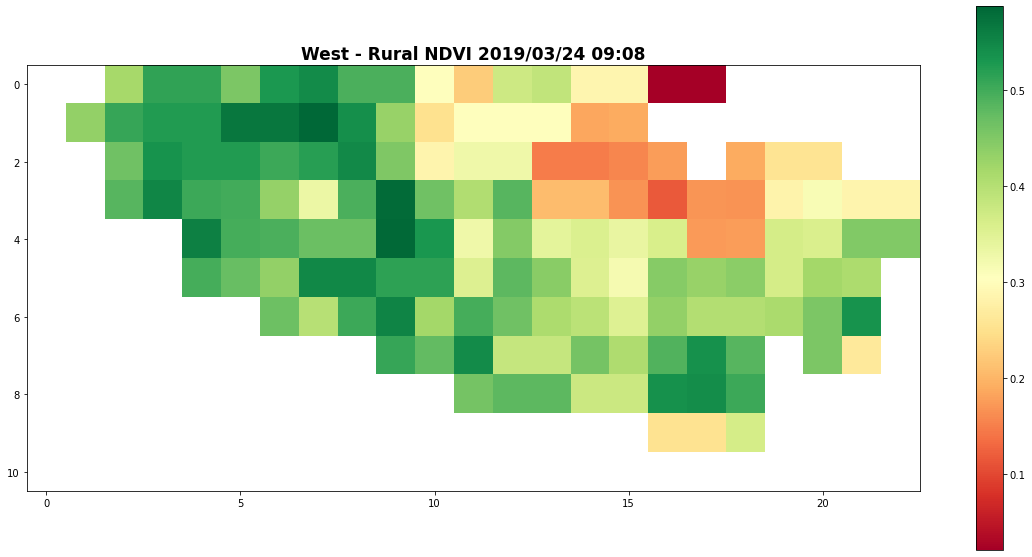

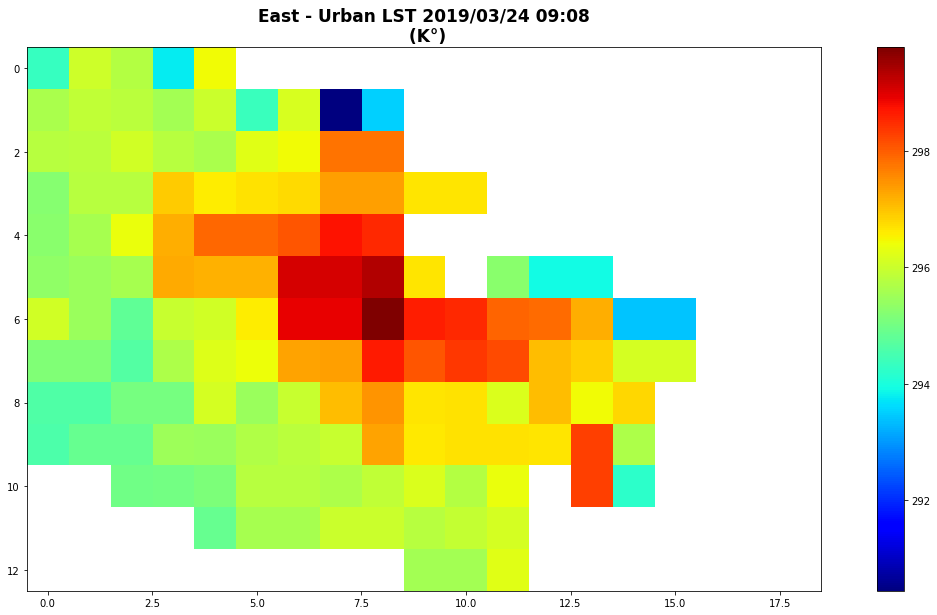

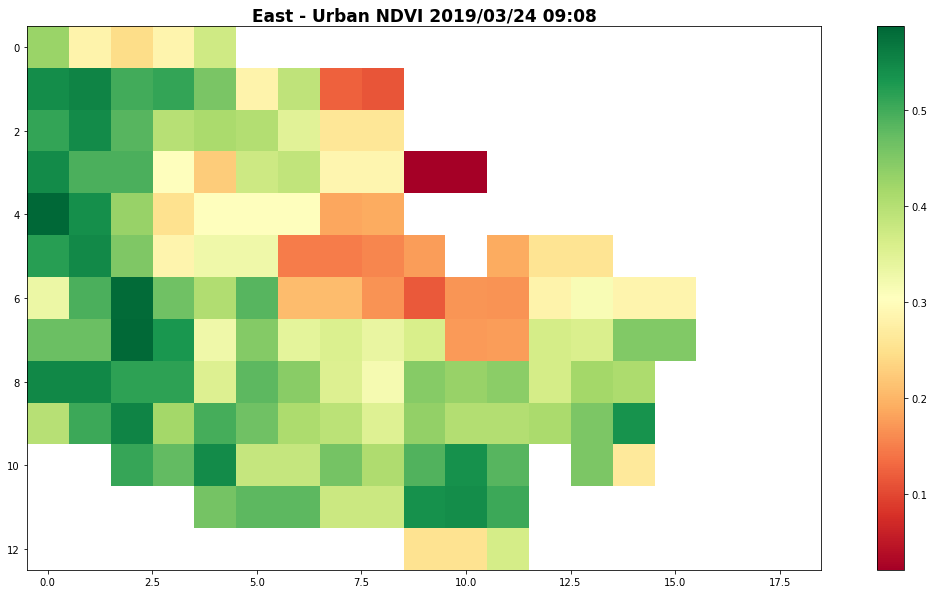

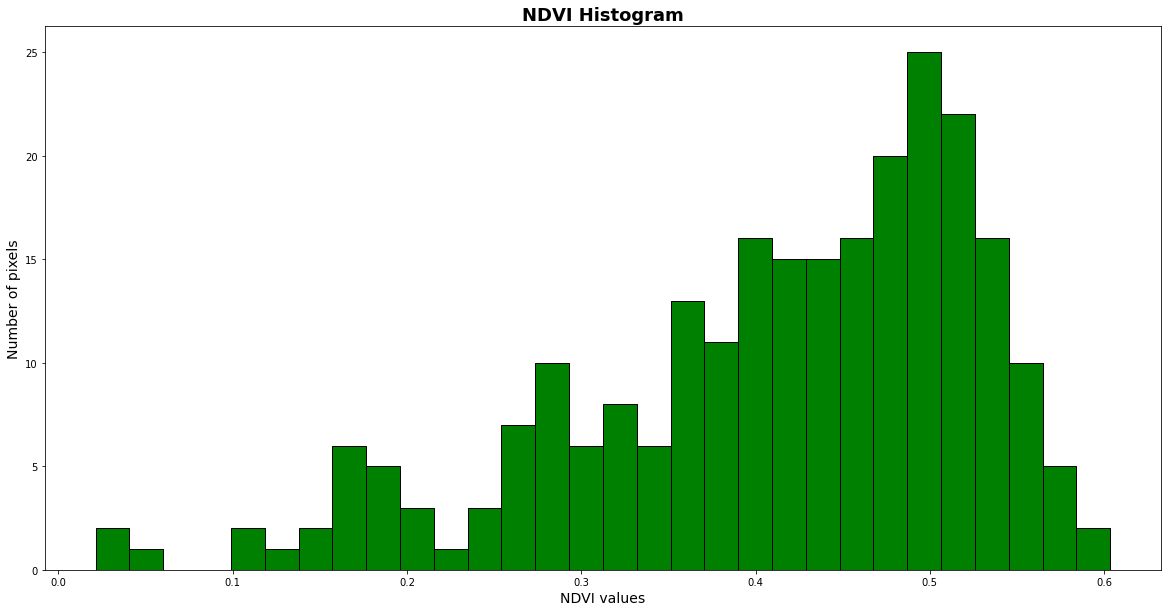

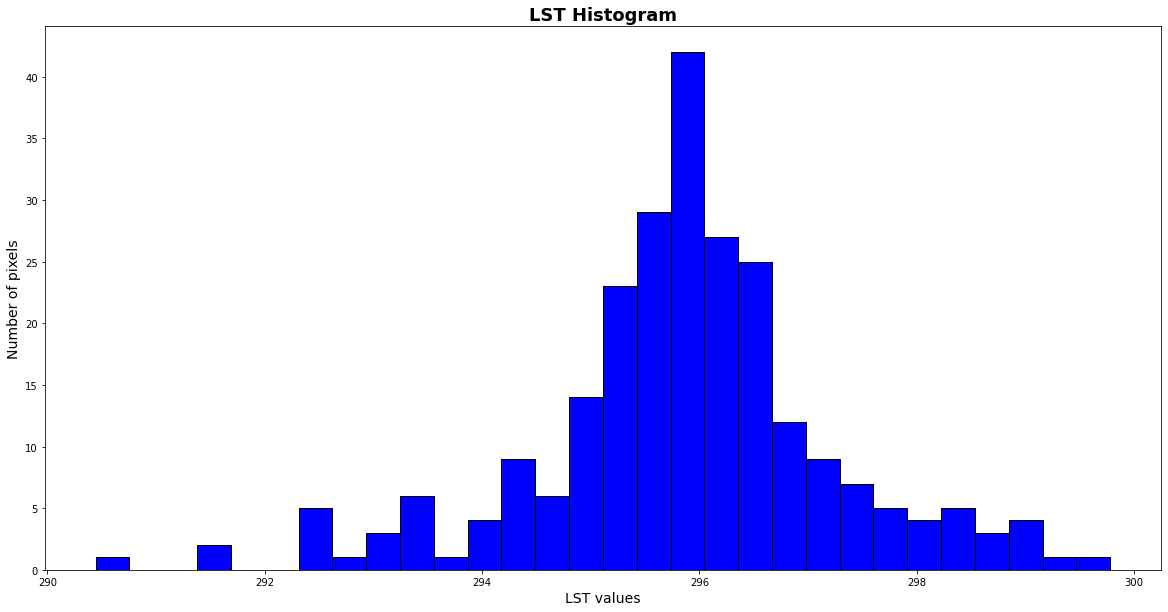

###################


LST mean:
310.99194 Kelvin
37.991943359375 Celcius
Max LST Pixel value: 
316.982 Kelvin
43.98199462890625 Celcius

LST mean West:
313.59613 Kelvin
40.59613037109375 Celcius

Max LST Pixel value West: 
316.982 Kelvin
43.98199462890625 Celcius

LST mean East:
314.01984 Kelvin
41.01983642578125 Celcius

Max LST Pixel value East: 
316.982 Kelvin
43.98199462890625 Celcius

NDVI mean Malta:
0.19041604

NDVI mean West:
0.20727551

NDVI mean East:
0.20532313

SUHI MAX:
43.77471923828125

SUHI MEAN:
-0.00195238


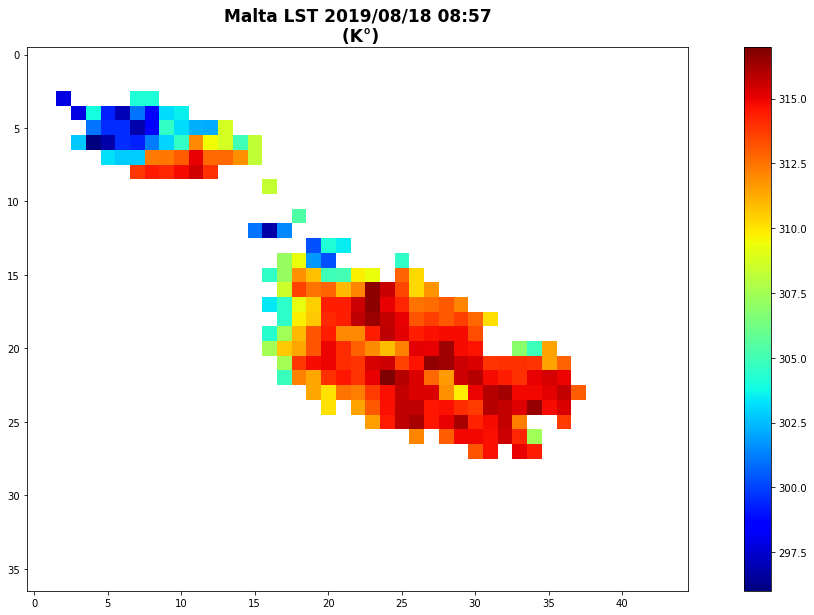

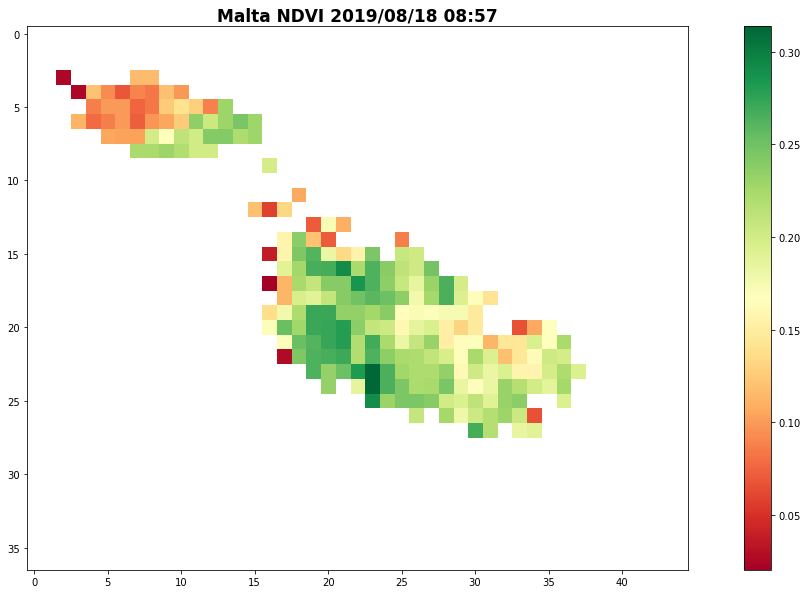

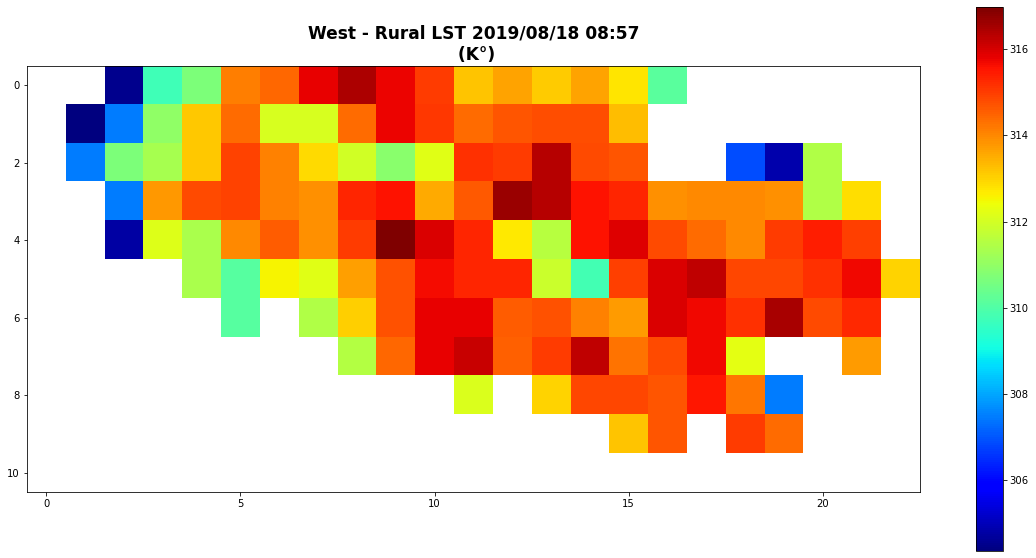

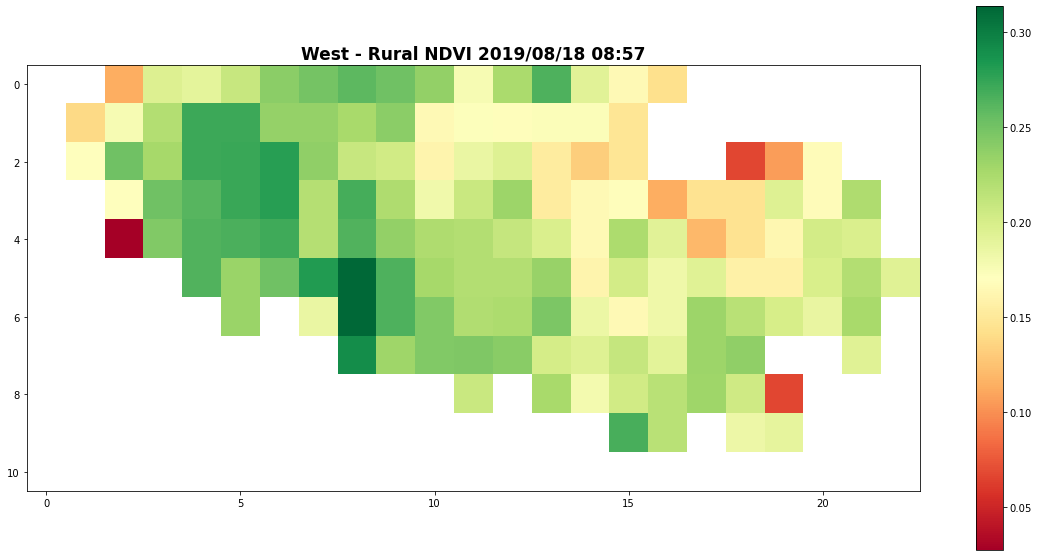

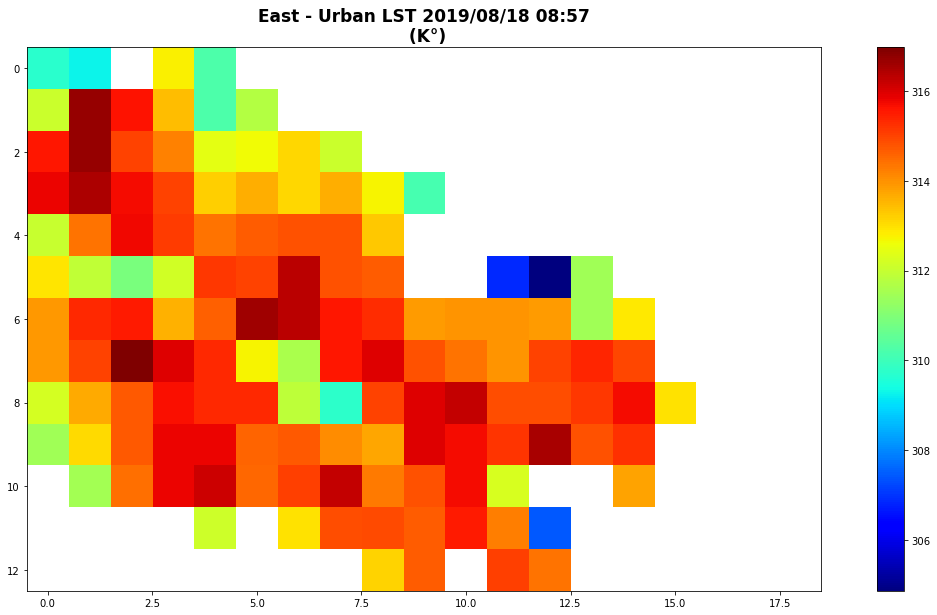

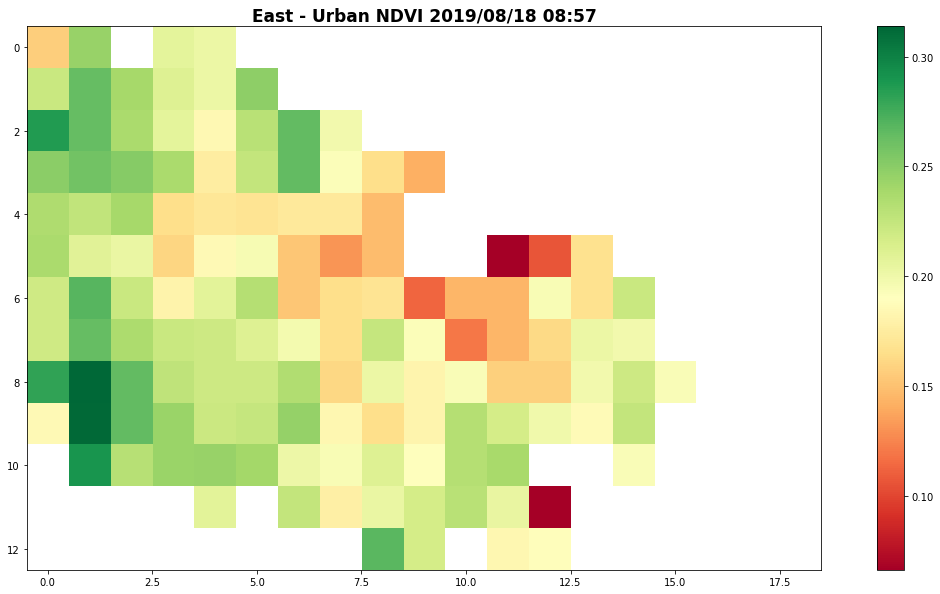

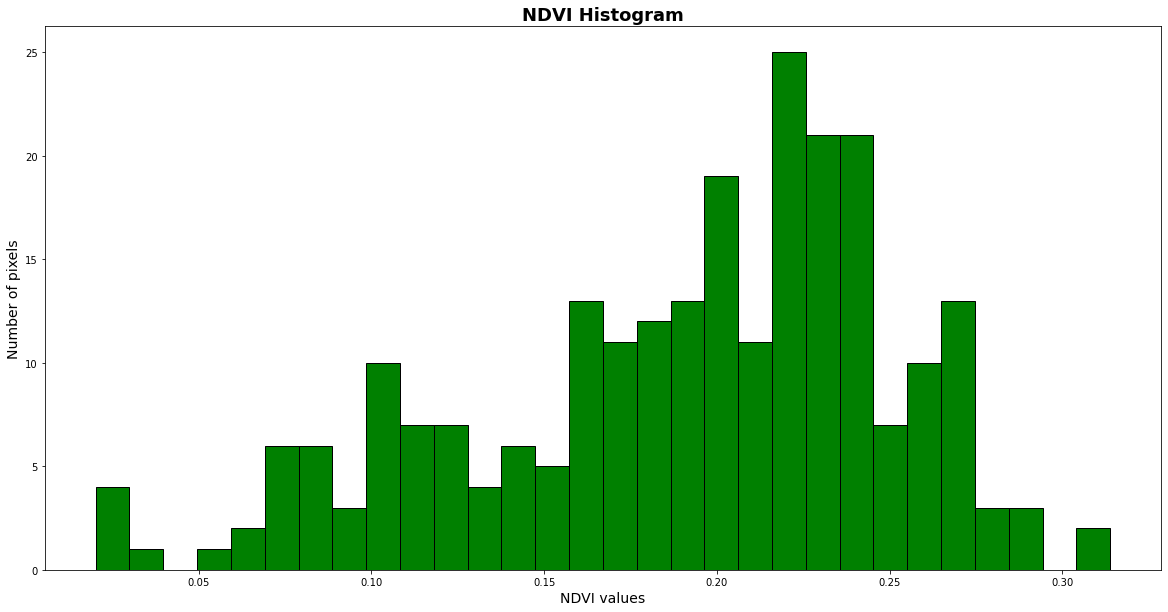

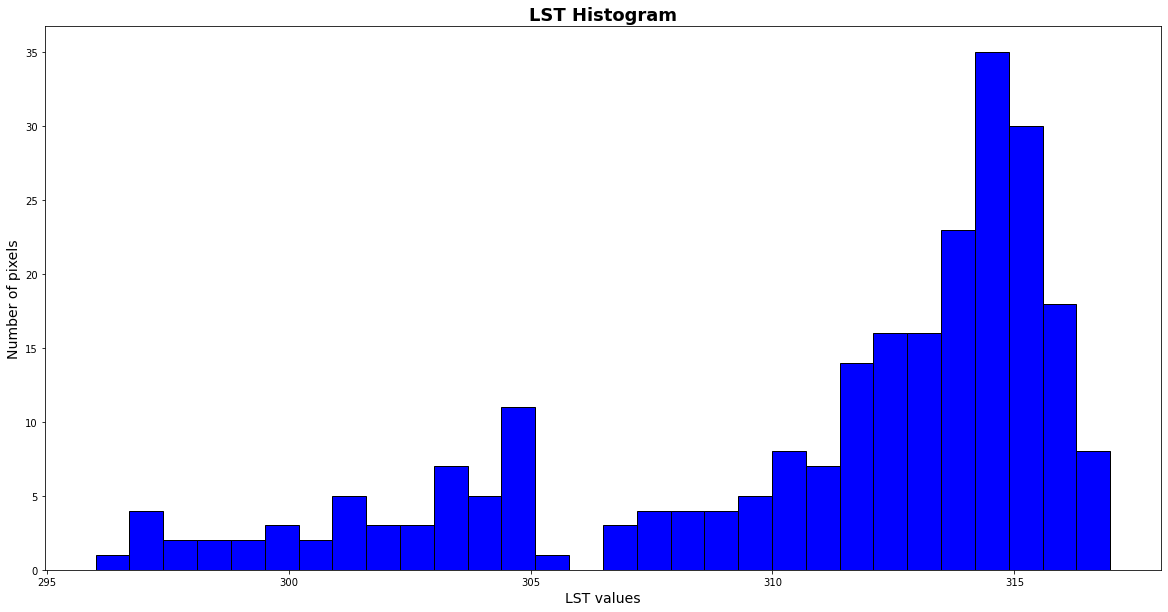

###################


LST mean:
312.79752 Kelvin
39.797515869140625 Celcius
Max LST Pixel value: 
317.172 Kelvin
44.1719970703125 Celcius

LST mean West:
313.53345 Kelvin
40.533447265625 Celcius

Max LST Pixel value West: 
317.172 Kelvin
44.1719970703125 Celcius

LST mean East:
313.84467 Kelvin
40.84466552734375 Celcius

Max LST Pixel value East: 
317.172 Kelvin
44.1719970703125 Celcius

NDVI mean Malta:
0.20647804

NDVI mean West:
0.21130252

NDVI mean East:
0.20974222

SUHI MAX:
43.960693359375

SUHI MEAN:
-0.0015603006


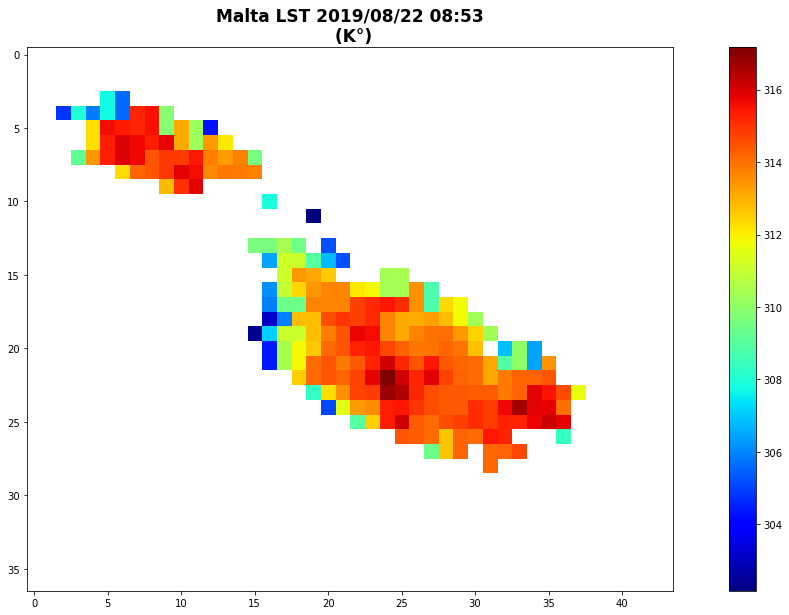

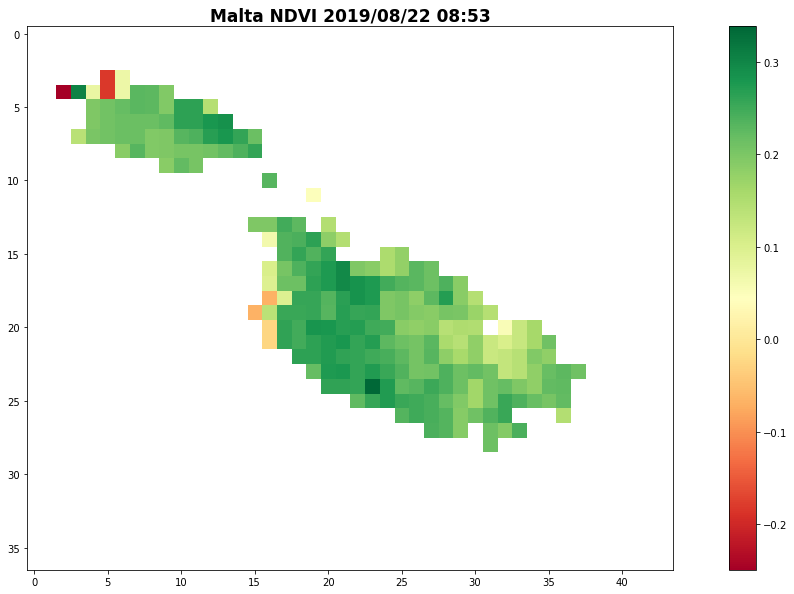

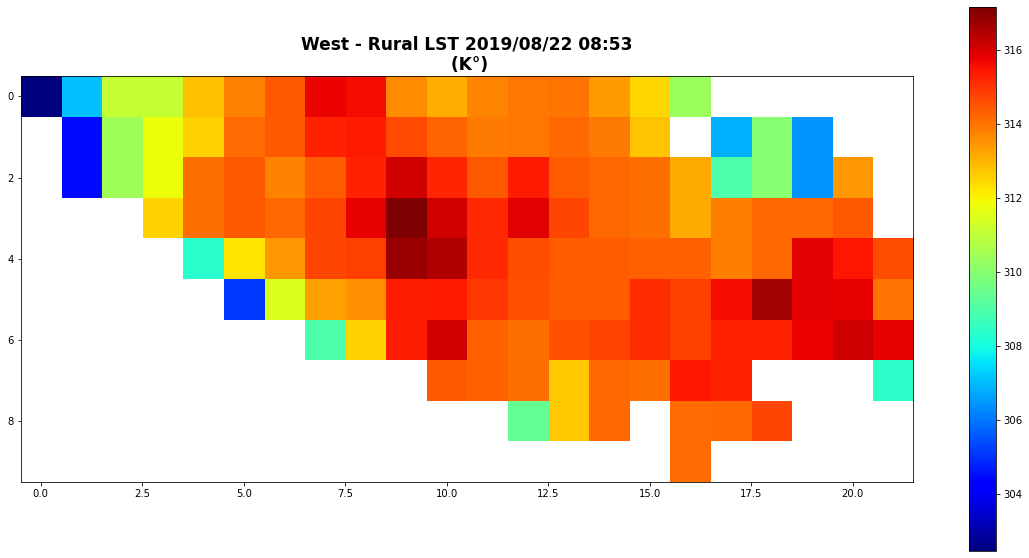

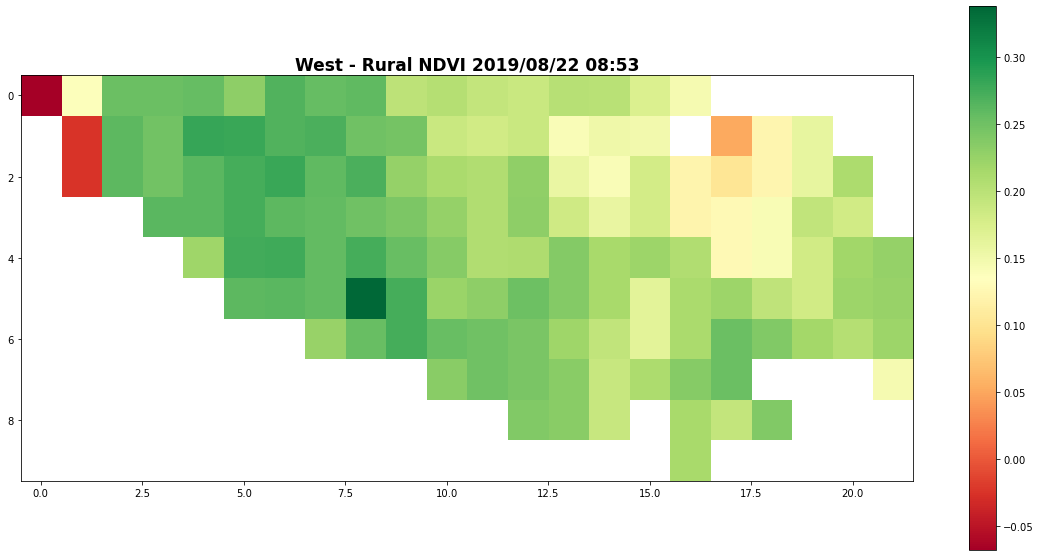

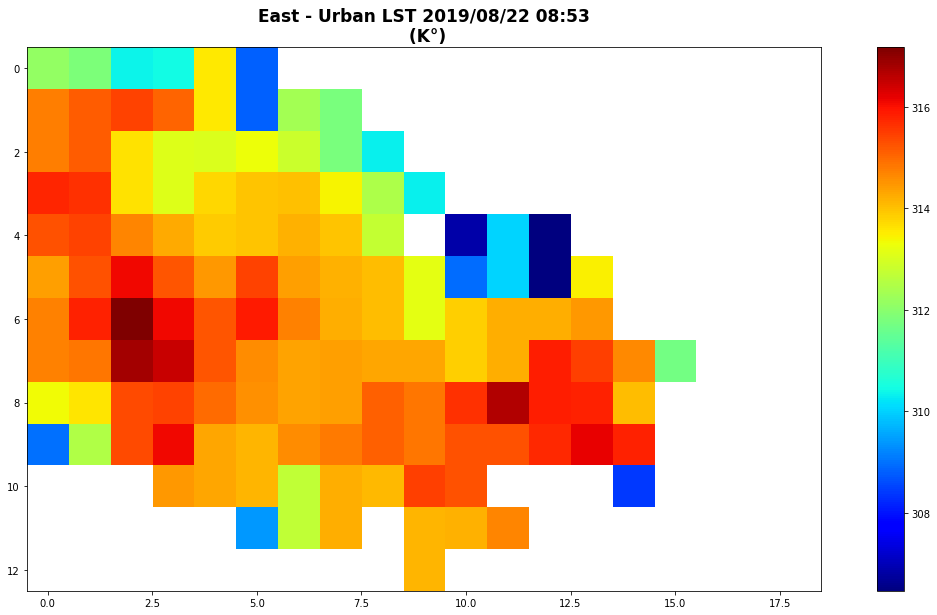

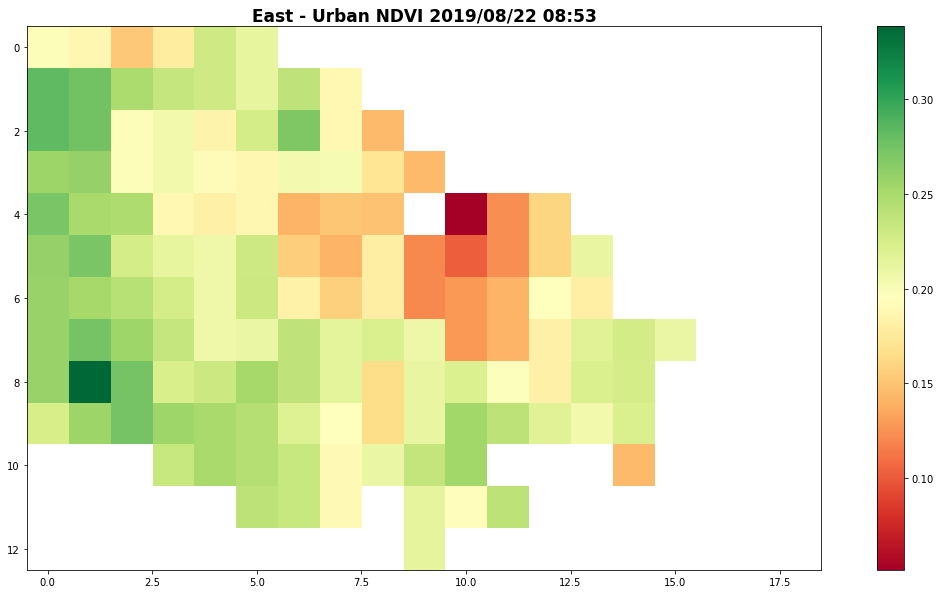

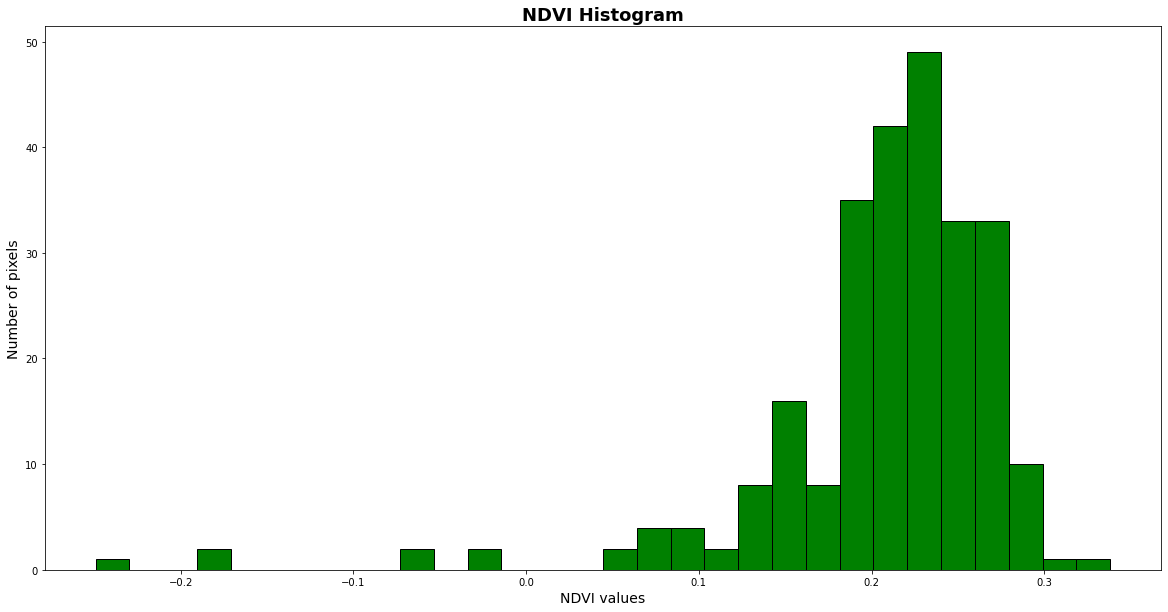

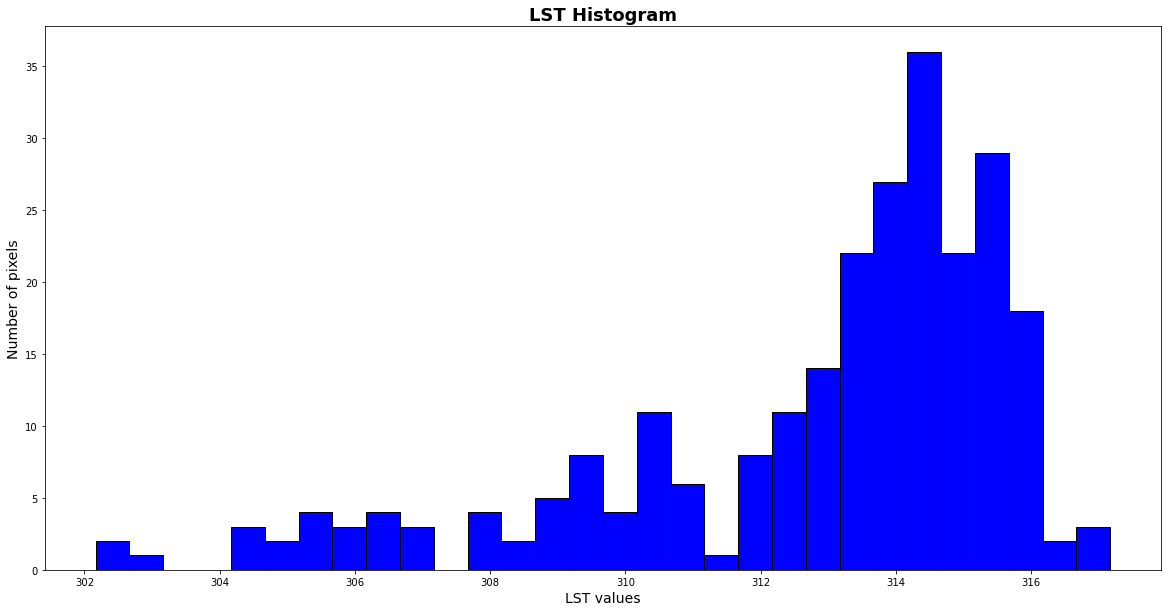

###################


LST mean:
287.64972 Kelvin
14.64971923828125 Celcius
Max LST Pixel value: 
297.402 Kelvin
24.402008056640625 Celcius

LST mean West:
286.09708 Kelvin
13.097076416015625 Celcius

Max LST Pixel value West: 
295.642 Kelvin
22.641998291015625 Celcius

LST mean East:
287.78284 Kelvin
14.7828369140625 Celcius

Max LST Pixel value East: 
296.0 Kelvin
23.0 Celcius

NDVI mean Malta:
0.14871918

NDVI mean West:
0.11200156

NDVI mean East:
0.12591049

SUHI MAX:
22.88800048828125

SUHI MEAN:
0.01390893


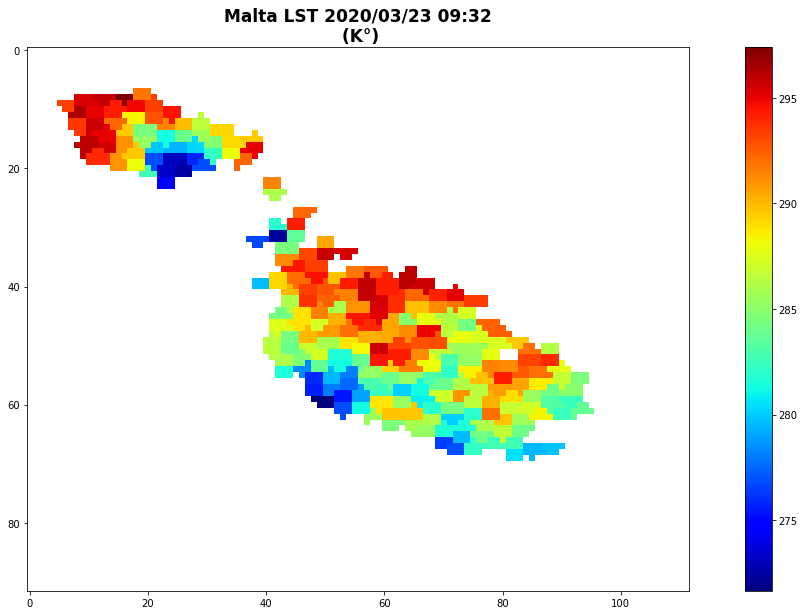

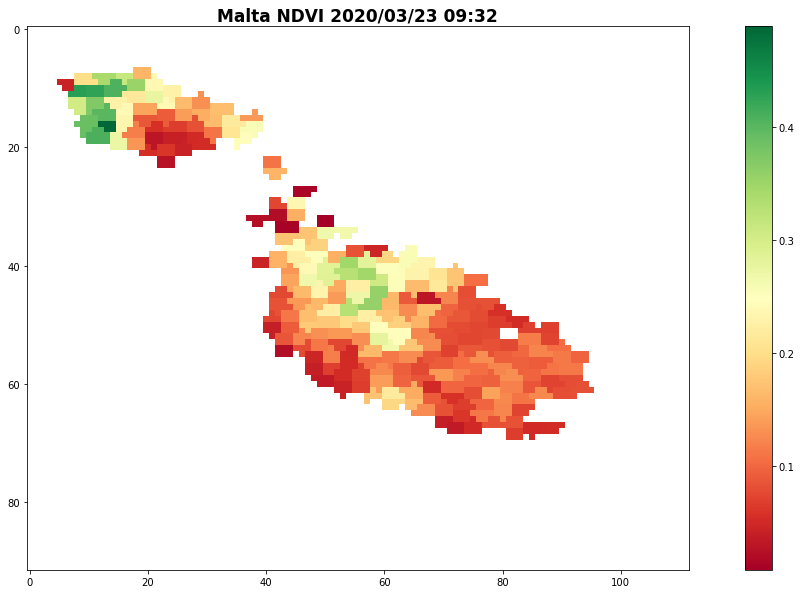

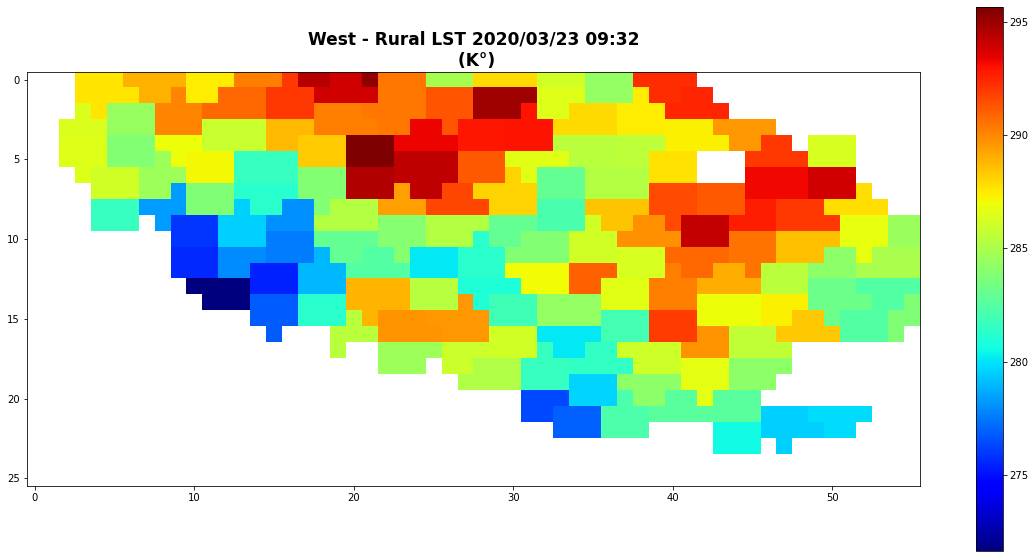

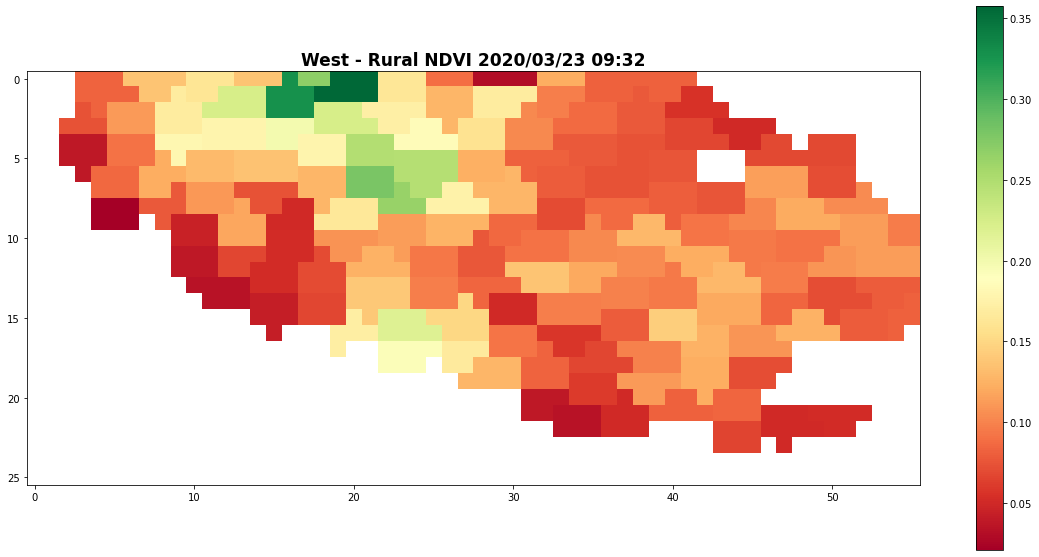

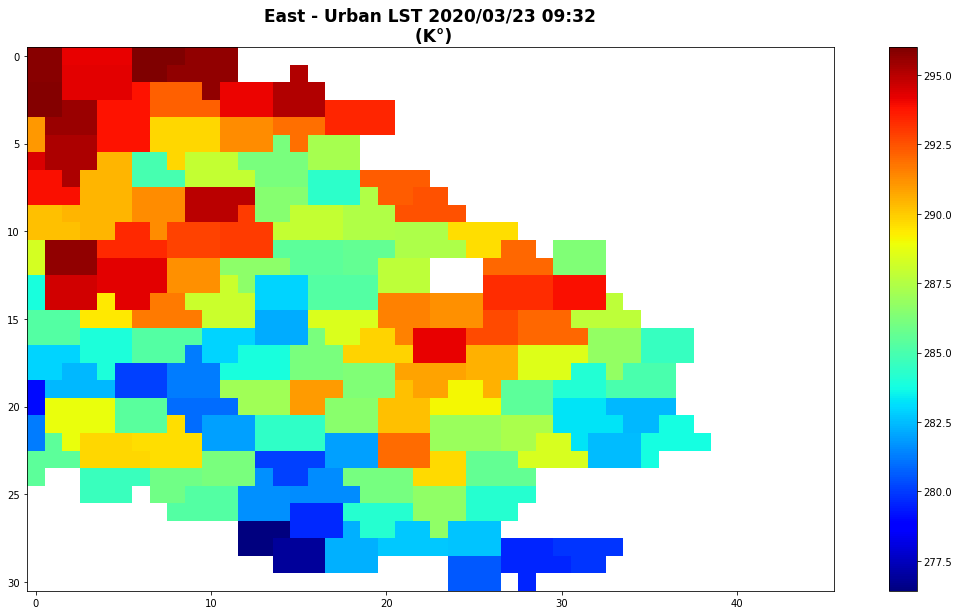

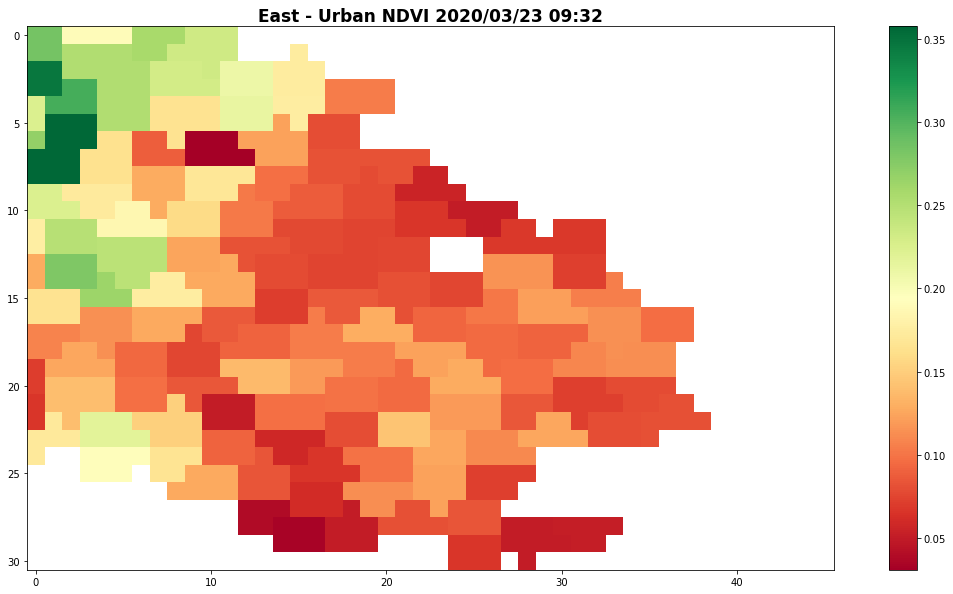

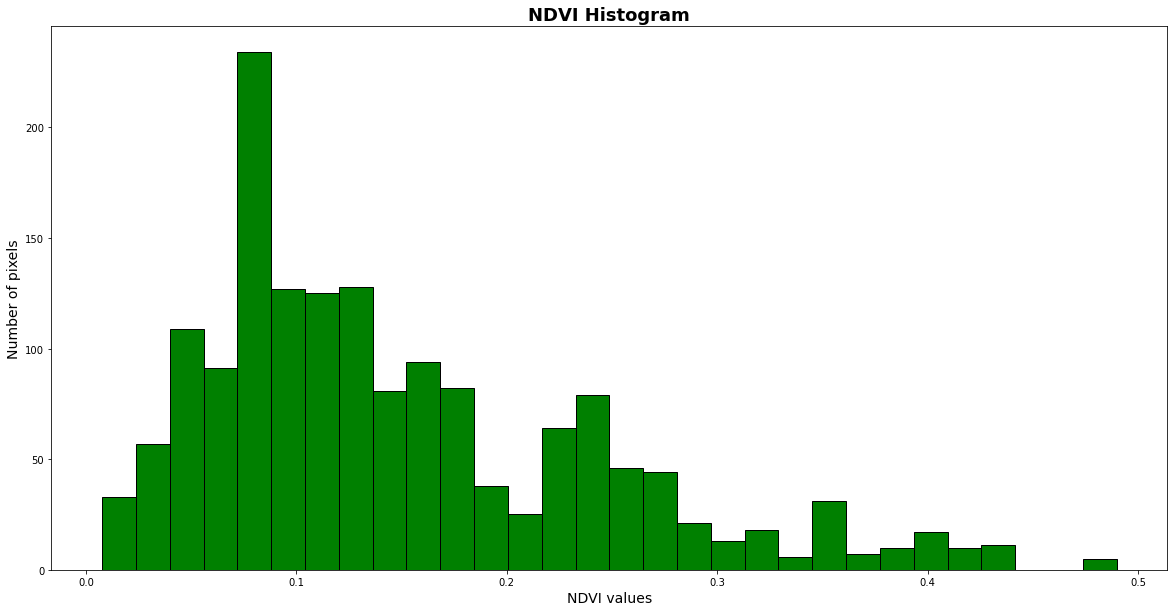

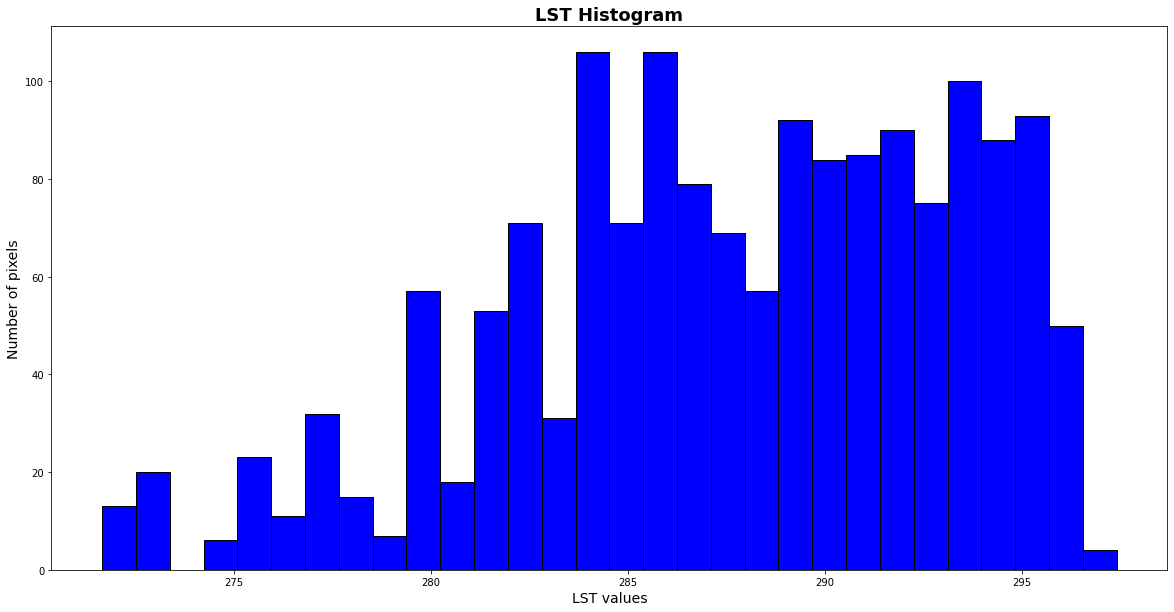

###################


LST mean:
289.93616 Kelvin
16.9361572265625 Celcius
Max LST Pixel value: 
298.604 Kelvin
25.60400390625 Celcius

LST mean West:
286.92242 Kelvin
13.92242431640625 Celcius

Max LST Pixel value West: 
295.432 Kelvin
22.4320068359375 Celcius

LST mean East:
287.56885 Kelvin
14.56884765625 Celcius

Max LST Pixel value East: 
298.314 Kelvin
25.313995361328125 Celcius

NDVI mean Malta:
0.20617442

NDVI mean West:
0.14672698

NDVI mean East:
0.15174653

SUHI MAX:
25.167266845703125

SUHI MEAN:
0.0050195456


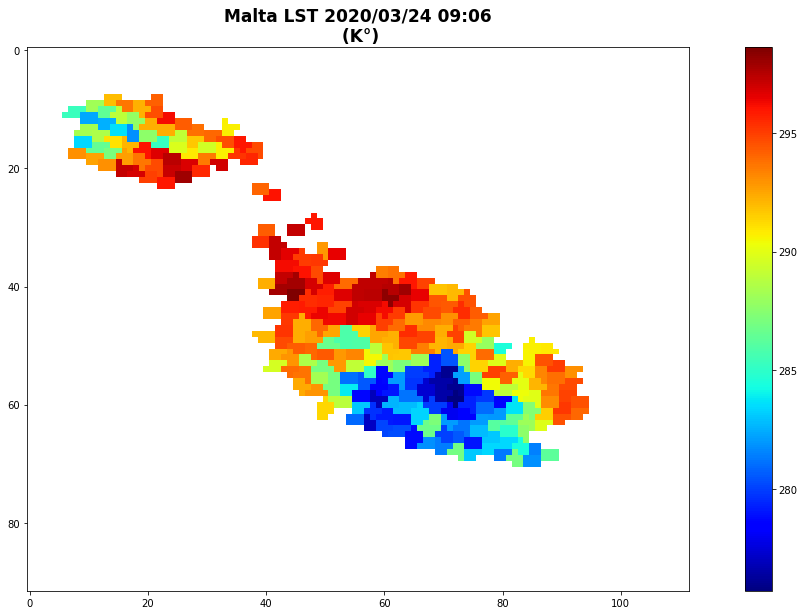

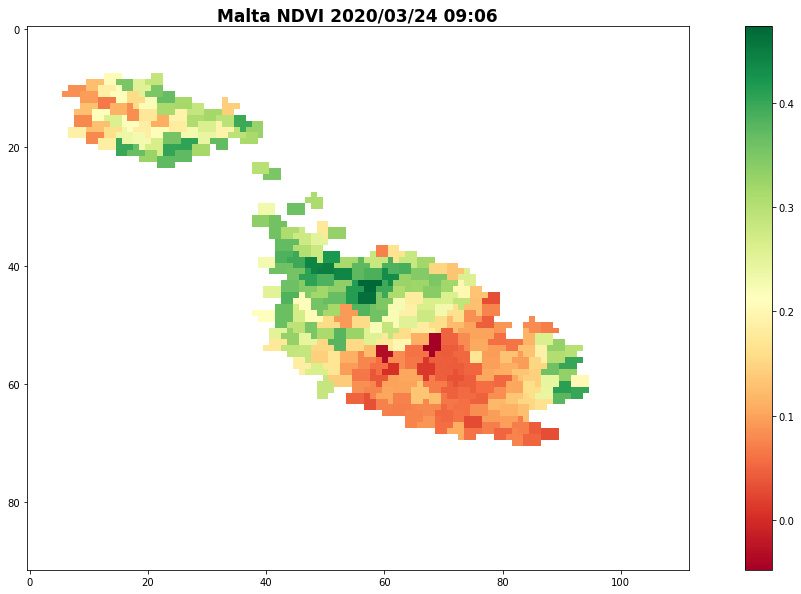

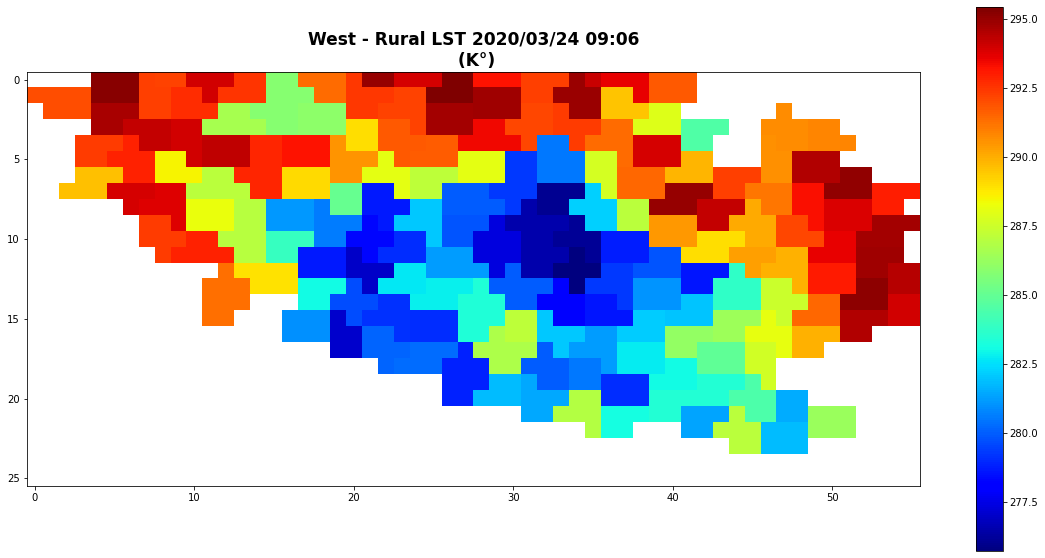

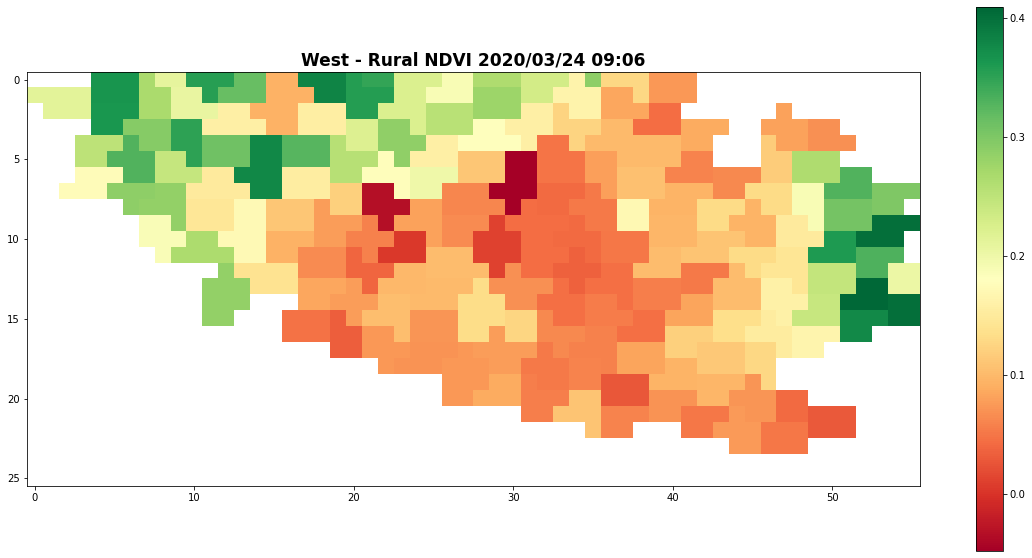

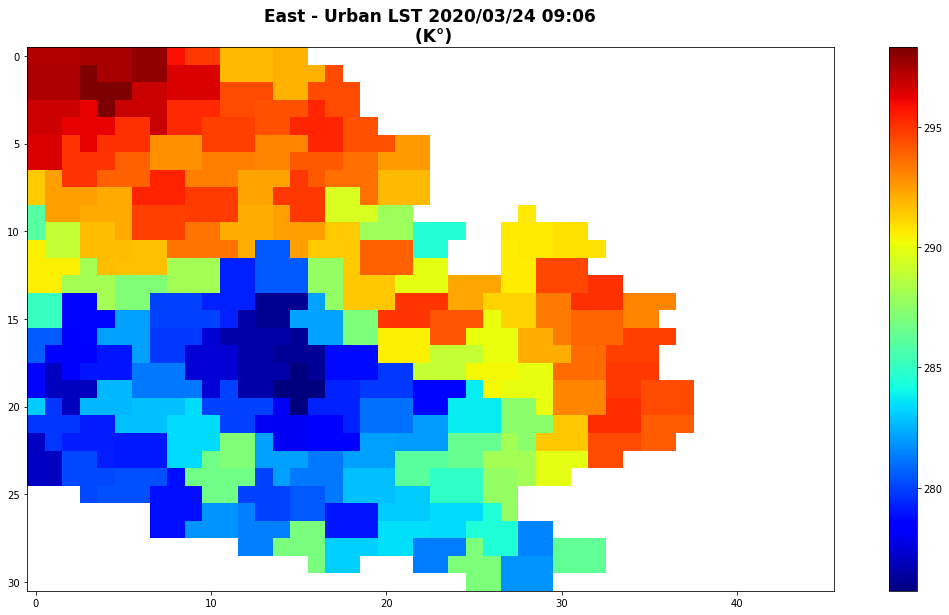

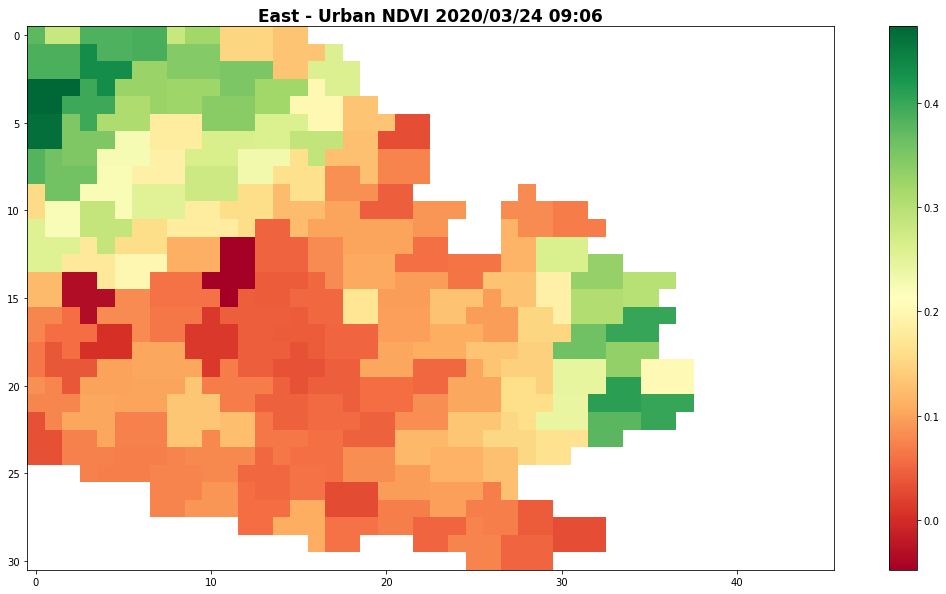

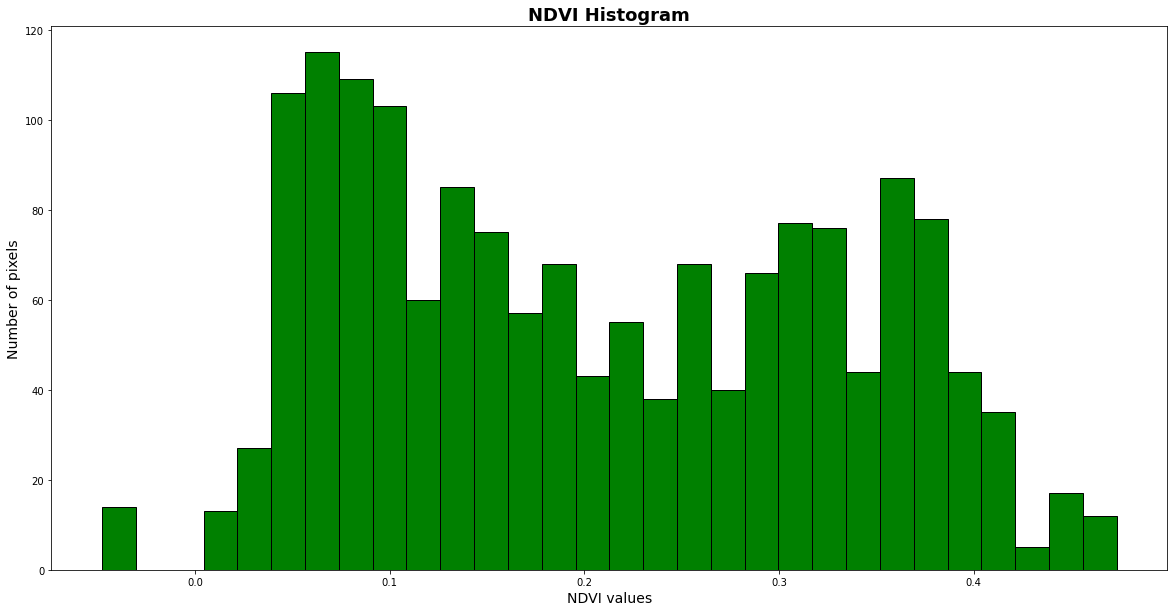

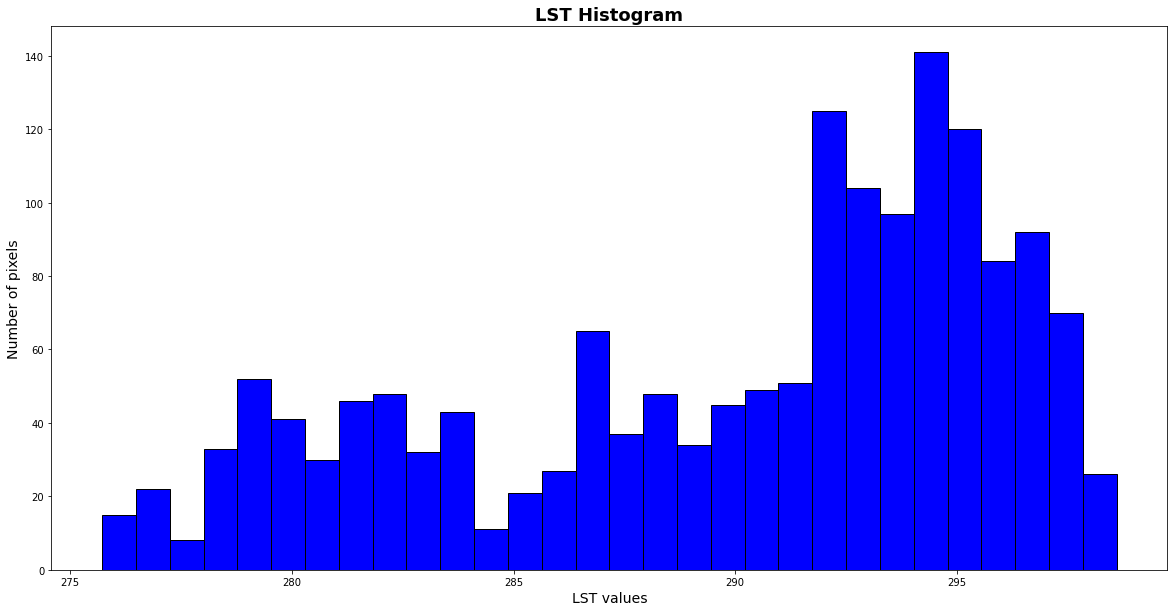

###################




In [10]:
for root, dirs, files in os.walk(base_directory):
    path = root.split(os.sep)
    print('Directory open:')
    print(path)    
    ###Gathering Product details such as date & time and storing them
    for name in files:
        full_name.append(str(name))

        temp_product = str(name)[17:46] #30chars include: (0-2)Sat, (4-8)Sensor, (13-31)Type, Year, Month, Date, Time
        product_name.append(temp_product) 

        sat.append(temp_product[:3])
        sensor.append(temp_product[4:12])

        date = temp_product[16:24]
        date = date[:4] + '/' + date[4:6] + '/' + date[6:]
        date_format.append(date)

        time = temp_product[25:29]
        time = time[:2] + ':' + time[2:]
        time_format.append(time)

        ####
        ####
        #product to be used
        product_path = str(os.path.join(root, name))
        product_paths.append(product_path)
        archi=File(product_path)
        product = ProductIO.readProduct(archi)
        reader = snappy.ProductIO.getProductReader('SEN3')

        ##Subset to Malta
        product = Subset(product, geomMalta)
        ##Subset to West
        productWest = Subset(product, geomWest)
        ##Subset to East
        productEast = Subset(product, geomEast)
        
        ##
        ##Get LST Band
        #Malta
        lst_band = product.getBand('LST')
        lst_w = product.getSceneRasterWidth() # Get Band Width
        lst_h = product.getSceneRasterHeight() # Get Band Height
        #West
        lst_band_west = productWest.getBand('LST')
        lst_w_west = productWest.getSceneRasterWidth()
        lst_h_west = productWest.getSceneRasterHeight() 
        #East
        lst_band_east = productEast.getBand('LST')
        lst_w_east = productEast.getSceneRasterWidth()
        lst_h_east = productEast.getSceneRasterHeight()         

        ##Get NDVI Band
        #Malta
        ndvi_band = product.getBand('NDVI')
        ndvi_w = product.getSceneRasterWidth() # Get Band Width
        ndvi_h = product.getSceneRasterHeight() # Get Band Height
        #West
        ndvi_band_west = productWest.getBand('NDVI')
        ndvi_w_west = productWest.getSceneRasterWidth() # Get Band Width
        ndvi_h_west = productWest.getSceneRasterHeight()
        #East
        ndvi_band_east = productEast.getBand('NDVI')
        ndvi_w_east = productEast.getSceneRasterWidth() # Get Band Width
        ndvi_h_east = productEast.getSceneRasterHeight()

        ##Create empty arrays
        #Malta
        lst_band_data = np.zeros(lst_w * lst_h, np.float32)
        ndvi_band_data = np.zeros(ndvi_w * ndvi_h, np.float32)
        #West
        lst_band_data_west = np.zeros(lst_w_west * lst_h_west, np.float32)
        ndvi_band_data_west = np.zeros(ndvi_w_west * ndvi_h_west, np.float32)
        #East
        lst_band_data_east = np.zeros(lst_w_east * lst_h_east, np.float32)
        ndvi_band_data_east = np.zeros(ndvi_w_east * ndvi_h_east, np.float32)

        ##Populate arrays with pixel value
        #Malta
        lst_band.readPixels(0, 0, lst_w, lst_h, lst_band_data) 
        ndvi_band.readPixels(0, 0, ndvi_w, ndvi_h, ndvi_band_data)
        #East
        lst_band_east.readPixels(0, 0, lst_w_east, lst_h_east, lst_band_data_east) 
        ndvi_band_east.readPixels(0, 0, ndvi_w_east, ndvi_h_east, ndvi_band_data_east)
        #West
        lst_band_west.readPixels(0, 0, lst_w_west, lst_h_west, lst_band_data_west) 
        ndvi_band_west.readPixels(0, 0, ndvi_w_west, ndvi_h_west, ndvi_band_data_west)

        ##Reshape
        #Malta
        lst_band_data.shape = lst_h, lst_w
        ndvi_band_data.shape = ndvi_h, ndvi_w
        #East
        lst_band_data_east.shape = lst_h_east, lst_w_east
        ndvi_band_data_east.shape = ndvi_h_east, ndvi_w_east
        #West
        lst_band_data_west.shape = lst_h_west, lst_w_west
        ndvi_band_data_west.shape = ndvi_h_west, ndvi_w_west

        ###Collecting Data
        ##LST
        #Malta
        no_nan_lst_band_data = lst_band_data[~np.isnan(lst_band_data)]
        print('LST mean:')
        mean = np.mean(no_nan_lst_band_data)
        print(str(mean) + ' Kelvin')
        print(str(mean - 273) + ' Celcius')
        lst_mean.append(mean - 273)

        print('Max LST Pixel value: ')
        max = np.amax(no_nan_lst_band_data)
        print(str(max) + ' Kelvin')
        print(str((max - 273)) + ' Celcius')
        lst_max.append(max - 273)
        #West
        no_nan_lst_band_data_west = lst_band_data_west[~np.isnan(lst_band_data_west)]
        print('\nLST mean West:')
        mean_west = np.mean(no_nan_lst_band_data_west)
        print(str(mean_west) + ' Kelvin')
        print(str(mean_west - 273) + ' Celcius')
        lst_mean_west.append(mean_west - 273)

        print('\nMax LST Pixel value West: ')
        max_west = np.amax(no_nan_lst_band_data_west)
        print(str(max_west) + ' Kelvin')
        print(str((max_west - 273)) + ' Celcius')
        lst_max_west.append(max_west - 273)
        #East
        no_nan_lst_band_data_east = lst_band_data_east[~np.isnan(lst_band_data_east)]
        print('\nLST mean East:')
        mean_east = np.mean(no_nan_lst_band_data_east)
        print(str(mean_east) + ' Kelvin')
        print(str(mean_east - 273) + ' Celcius')
        lst_mean_east.append(mean_east - 273)

        print('\nMax LST Pixel value East: ')
        max_east = np.amax(no_nan_lst_band_data_east)
        print(str(max_east) + ' Kelvin')
        print(str((max_east - 273)) + ' Celcius')
        lst_max_east.append(max_east - 273)

        ##NDVI
        #Malta
        no_nan_ndvi_band_data = ndvi_band_data[~np.isnan(ndvi_band_data)]
        print('\nNDVI mean Malta:')
        mean = np.mean(no_nan_ndvi_band_data)
        print(str(mean))        
        ndvi.append(mean)
        #West
        no_nan_ndvi_band_data_west = ndvi_band_data_west[~np.isnan(ndvi_band_data_west)]
        print('\nNDVI mean West:')
        mean_west = np.mean(no_nan_ndvi_band_data_west)
        print(str(mean_west))      
        ndvi_west.append(mean_west)  
        #East
        no_nan_ndvi_band_data_east = ndvi_band_data_east[~np.isnan(ndvi_band_data_east)]
        print('\nNDVI mean East:')
        mean_east = np.mean(no_nan_ndvi_band_data_east)
        print(str(mean_east))  
        ndvi_east.append(mean_east)  

        ##SUHI_MAX
        suhi_m = max_east - mean_west
        suhi_max.append(suhi_m)  
        print('\nSUHI MAX:\n' + str(suhi_m - 273))
        ##SUHI_MEAN
        suhi_mn = mean_east - mean_west
        suhi_mean.append(suhi_mn)
        print('\nSUHI MEAN:\n' + str(suhi_mn))

        ###
        #Plot the band       
        #Malta
        plotLstNdvi(lst_band_data, ndvi_band_data, date, time, "Malta")
        #West
        plotLstNdvi(lst_band_data_west, ndvi_band_data_west, date, time, "West - Rural")
        #East
        plotLstNdvi(lst_band_data_east, ndvi_band_data_east, date, time, "East - Urban")

        ####
        #Histogram
        histogram(no_nan_lst_band_data, no_nan_ndvi_band_data)

        #end
        print('###################\n\n')

In [ ]:
write_to_csv( sat, date_format, sensor, time_format, full_name, lst_mean, lst_max, ndvi, lst_mean_east, lst_max_east, lst_mean_west, lst_max_west, ndvi_east, ndvi_west, suhi_max, suhi_mean)
##https://forum.step.esa.int/t/sentinel-3-slstr-level-2-lst-cloud-mask/16471/2